In [1]:
from rdkit import DataStructs
from rdkit import Chem
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split, KFold, cross_val_score

import keras
from keras import layers
from keras.regularizers import l2
from keras.regularizers import l1
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#read the data
nims2 = pd.read_excel("GlassTransition.xlsx")
nims3 = pd.read_excel("Density.xlsx")
nims4 = pd.read_excel("Solubility.xlsx")

In [3]:
def train_model(model, X_train, y_train, epochs, batch_size, val_split):
    # Patient early stopping
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=200)
    
    """Train the model by feeding it data."""
    
    history = model.fit(x=X_train, y=y_train, validation_split=val_split, batch_size=batch_size,
                      epochs=epochs, shuffle=True, callbacks=[es]) 

    # The list of epochs is stored separately from the rest of history.
    epochs = history.epoch

    # To track the progression of training, gather a snapshot
    # of the model's mean squared error at each epoch. 

    return epochs, history

In [4]:
def plot_the_loss_curve(epochs, history):
    """Plot a curve of loss vs. epoch."""

    plt.figure()
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error")
    plt.title('model loss')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()  

In [5]:
def plotNNpredictor(X_train,X_test,y_train,y_test):
    plt.rcParams.update({'font.family':'Arial'})
    plt.scatter(y_train,best_model.predict(X_train), label = 'Train', c='blue')
    #plt.title('Neural Network Predictor')
    plt.xlabel('Measured Glass Transition Temperature')
    plt.ylabel('Predicted Glass Transition Temperature')
    plt.scatter(y_test,best_model.predict(X_test),c='red', label='Test')
    plt.plot([y_train.min()-25,y_train.max()+25], [y_train.min()-25,y_train.max()+25], color = 'black', label = 'y = x')
    plt.legend(loc=0)
    return plt

In [6]:
df = nims2

In [7]:
df.head()

,PID,Name,Molfile,SMILES,Glass transition temp.
0,P010001,polyethene,P010001.mol,*C*,-54
1,P010002,poly(prop-1-ene),P010002.mol,*CC(*)C,-3
2,P010003,poly(but-1-ene),P010003.mol,*CC(*)CC,-24.1
3,P010004,poly(pent-1-ene),P010004.mol,*CC(*)CCC,-37
4,P010006,poly(3-methylbut-1-ene),P010006.mol,*CC(*)C(C)C,56.6667


In [8]:
#Generate a new dataframe with only Smiles, Fingerprints, Monomer weight, Solubility Parameter, and Glass Transition Temperature
#Since this is an old NIMS file, we have to take the average column for each desired property.

mol_list = []
for i in range(len(df.SMILES)):
    try:
        element = df.SMILES[i]
        indexed = []
        mol = Chem.MolFromSmiles(str(element)) #Use RDKit to get mol objects from the SMILES strings
        mw = Chem.Descriptors.ExactMolWt(mol) #Get the monomer weight from the mol objects
        indexed.append(i)
        indexed.append(element)
        indexed.append(mol)
        indexed.append(mw)
        indexed.append(df['Glass transition temp.'][i])
        mol_list.append(indexed)
    except:
        pass

FP_list = []
numpyarrays = []

#Create Columns for Fingerprints and FPs as Numpy arrays. The arrays are easier to feed to the NN.
i = 0
baseData = np.arange(1,1)
for mol in mol_list:
    arr = np.zeros((1,))
    try:
        FP = Chem.RDKFingerprint(mol[2])
        FP_list.append(FP)
        DataStructs.ConvertToNumpyArray(FP, arr)
        numpyarrays.append(arr)
        row = np.array([mol[0], mol[1], FP, arr, mol[3],mol[4]], dtype = object)
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1 
    except:
        i = i+1
        pass

columnNames=["Index", "SMILES","RDKit FingerPrint","FP as Numpy array","Monomer_Weight","Glass_Transition"]
df = pd.DataFrame(data=baseData,columns=columnNames)

In [9]:
df

,Index,SMILES,RDKit FingerPrint,FP as Numpy array,Monomer_Weight,Glass_Transition
0,0,*C*,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.0157,-54
1,1,*CC(*)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",42.047,-3
2,2,*CC(*)CC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56.0626,-24.1
3,3,*CC(*)CCC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",70.0783,-37
4,4,*CC(*)C(C)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",70.0783,56.6667
...,...,...,...,...,...,...
7506,7508,*CC(F)(F)C1(F)C(*)CC(O)(C(F)(F)F)C1(F)F,"[0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, ...","[0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, ...",270.029,152
7507,7509,*CC(F)(F)C1(F)CC(CC(O)(C(F)(F)F)C(F)(F)F)CC1*,"[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...",330.067,98
7508,7510,*CC(F)(F)C1(F)CC(C(O)(C(F)(F)F)C(F)(F)F)CC1*,"[0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...",316.051,118
7509,7513,*CC(*)(F)C(=O)OCC(Cl)(Cl)Cl,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",219.926,127


In [10]:
#Remove rows with Tg values that cannot be converted to floats
index_names = []
for i in range(len(df['Glass_Transition'])):
    try:
        np.array(df.iloc[i]['Glass_Transition']).astype('float32')
    except:
        index_names.append(i)

df.drop(index=index_names, inplace = True)

In [11]:
#Convert values to numpy float arrays
Monomer_Weight = np.array(df['Monomer_Weight'].values).astype('float32')
Glass_Transition = np.array(df['Glass_Transition'].values).astype('float32')

props = np.hstack((Monomer_Weight[:,None], Glass_Transition[:,None]))

df_props = pd.DataFrame(data=props,columns=['Monomer_Weight','Glass_Transition'])
df_props

,Monomer_Weight,Glass_Transition
0,14.015650,-54.000000
1,42.046951,-3.000000
2,56.062599,-24.100000
3,70.078247,-37.000000
4,70.078247,56.666668
...,...,...
7381,270.029083,152.000000
7382,330.066620,98.000000
7383,316.050964,118.000000
7384,219.926086,127.000000


## Distribution Plots

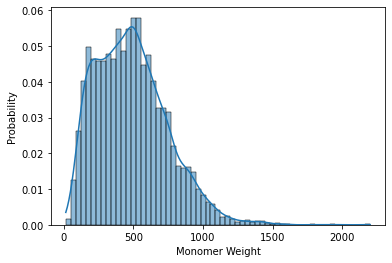

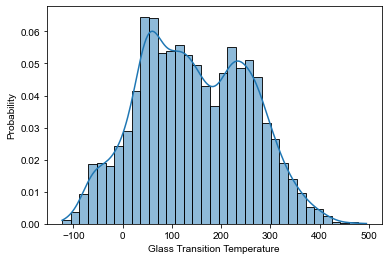

In [12]:
#Distribution Plot for monomer weight
dp = sns.histplot(x='Monomer_Weight',data=df_props, stat='probability', kde = True)
dp.set(xlabel='Monomer Weight')
plt.rcParams.update({'font.family':'Arial'})
plt.show()

#Distribution Plot for glass transition temperature
dp = sns.histplot(x='Glass_Transition',data=df_props, stat ='probability', kde = True)
dp.set(xlabel='Glass Transition Temperature')
plt.rcParams.update({'font.family':'Arial'})
plt.show()

#plt.savefig('Monomer_weight_dist.png')
#plt.savefig('Sol_Param_dist.png')
#plt.savefig('Glass_Trans_dist.png')

# Keras Tuner

Below shows the code defining the deep neural network model, which has most hyperparameters chosen through Keras Tuner, a method similar to Scikit Learn's GridSearchCV(). Essentially the model starts being built by defining an input layer, which is a layer that takes in an expected tensor shape. The tensor at hand is defined by our feature vector, which in this case is a 2049-component vector. Each feature vector is individually fed into the model, so our input is really 1-dimensional, and each component of the feature vector has its own node. After this we define 3 hidden layers, which are fully connected to the layer before and after. By fully connected, it is meant that every node in the layer is connected to every node in the layer before and after. Lastly there is a final layer that only has one node, which outputs a single value, in this case being a property (glass transition temperature, solubility temperature, etc.).

The tuner works by taking multiple 'choice' parameters defined throughout the model, and running multiple variations of these parameters in the form of different models. Instead of fully running the different models, only a short sample of data is trained and tested. The tuner saves the data of all of these different model runs on your local machine and when finished going through all of the different combinations of parameters, will choose the model with the smallest validation loss (or whatever else you choose under the objective argument in kt.Hyperband() which initiates the search). This means that when there are many different values for each parameter that you would like to search for, the number of combinations dramatically increases, and the time to find the best model will also increase.

In the model below, choices are made for the tuner to search through:
- l2 or l1 regularization (this will be set at every hidden layer)
    - regularization rate: search between directly defined values
- Number of nodes in each hidden layer
    - search between a minimum and maximum number of nodes with a step size
- Dropout rate between each hidden layer
    - dropout allows for random removal of nodes during training to minimize overfitting
- Learning rate: search between directly defined values

In [13]:
#!pip install keras-tuner -q
from tensorflow import keras #Even though this was imported more directly up above, import again to avoid errors.
import keras_tuner as kt
import os

In [14]:
#Wrapper for regulaization, will allow tuner to choose best regularization and value
def reg_wrapper(type, value):
    if type == 'l2':
        return keras.regularizers.l2(value)
    if type == 'l1':
        return keras.regularizers.l1(value)

def build_model(hp):
    reg = reg_wrapper(hp.Choice('type', ['l1', 'l2']), hp.Choice('reg_value', values=[0.01,0.001,0.1,0.005,0.05]))
    
    # Most simple tf.keras models are sequential.
    model = keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    # Describe the topography of the model. 

    # Implement L2 regularization in the first hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units1", min_value=16, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden1'))
    #add Dropout under first hidden layer
    model.add(keras.layers.Dropout(hp.Choice("Dropout_rate1", values=[0.0,0.1,0.2,0.3,0.4,0.5])))
    
    # Implement L2 regularization in the second hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units2", min_value=16, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden2'))
    #add Dropout under second hidden layer
    model.add(keras.layers.Dropout(hp.Choice("Dropout_rate2", values=[0.0,0.1,0.2,0.3,0.4,0.5])))
    
    # Implement L2 regularization in the third hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units3", min_value=16, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden3'))
    
    #no dropout layer added before the output layer. 
    
    # Define the output layer.
    model.add(keras.layers.Dense(units=1,
                                  activation='linear',
                                  name='Output',
                                  ))                              

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-1,1e-2,1e-3,1e-4])),
        loss="mean_squared_error",
        metrics=[keras.metrics.MeanSquaredError()]
    )

    return model 

In [15]:
df_GT = df.dropna(subset=['Glass_Transition'])

X1 = np.array(list(df_GT['FP as Numpy array'].values)).astype('float64')
X2 = np.array([list(df_GT['Monomer_Weight'].values)]).astype('float64')
X2=X2.T #Transpose array to line up with X1

#Standard Normalization (Z-score)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X2)
X2 = scaler.transform(X2)

X = np.concatenate((X1, X2), axis=1)

y = np.array(df_GT['Glass_Transition'].values).astype('float32')

input_shape = X.shape[1]

In [16]:
#Partitioning the Monomer Weight data into an 80/20 train/validation split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [17]:
tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=300,
    directory=os.path.normpath(r'C:\Users\Marco\Documents'),
    project_name = "Final_Report_Tg"
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2,shuffle=True)

INFO:tensorflow:Reloading Oracle from existing project C:\Users\Marco\Documents\Final_Report_Tg\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Marco\Documents\Final_Report_Tg\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [18]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate'] + ['type'] + ['reg_value'] + ['Dropout_rate']:
    print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

units1 272
units2 176
units3 336
learning_rate 0.001
type l2
reg_value 0.005
Dropout_rate 0.1


In [19]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden1 (Dense)              (None, 272)               557600    
_________________________________________________________________
dropout (Dropout)            (None, 272)               0         
_________________________________________________________________
Hidden2 (Dense)              (None, 176)               48048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 176)               0         
_________________________________________________________________
Hidden3 (Dense)              (None, 336)               59472     
_________________________________________________________________
Output (Dense)               (None, 1)                 337       
Total params: 665,457
Trainable params: 665,457
Non-trainable params: 0
__________________________________________________

In [20]:
#Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)

#Train Model
history = best_model.fit(
    X_train, 
    y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=10,
    shuffle=True,
    callbacks=[es]
)

#Get number of Epochs after early stoppage
epochs = history.epoch

# Model prediction against the test set.
y_pred_test = best_model.predict(X_test)

Epoch 1/1000
467/467 [==============================] - 2s 4ms/step - loss: 431.5073 - mean_squared_error: 406.6529 - val_loss: 1424.1163 - val_mean_squared_error: 1398.4580
Epoch 2/1000
467/467 [==============================] - 1s 3ms/step - loss: 307.7004 - mean_squared_error: 281.7407 - val_loss: 1457.1981 - val_mean_squared_error: 1430.8605
Epoch 3/1000
467/467 [==============================] - 2s 3ms/step - loss: 236.9556 - mean_squared_error: 210.4210 - val_loss: 1373.3223 - val_mean_squared_error: 1346.6188
Epoch 4/1000
467/467 [==============================] - 2s 3ms/step - loss: 217.3705 - mean_squared_error: 190.5421 - val_loss: 1333.0911 - val_mean_squared_error: 1306.1346
Epoch 5/1000
467/467 [==============================] - 1s 3ms/step - loss: 231.7204 - mean_squared_error: 204.5773 - val_loss: 1414.8640 - val_mean_squared_error: 1387.5386
Epoch 6/1000
467/467 [==============================] - 1s 3ms/step - loss: 215.4110 - mean_squared_error: 187.9329 - val_loss: 13

Epoch 48/1000
467/467 [==============================] - 1s 3ms/step - loss: 151.7398 - mean_squared_error: 118.8349 - val_loss: 1391.5685 - val_mean_squared_error: 1358.6464
Epoch 49/1000
467/467 [==============================] - 1s 3ms/step - loss: 145.3250 - mean_squared_error: 112.4485 - val_loss: 1329.2216 - val_mean_squared_error: 1296.4031
Epoch 50/1000
467/467 [==============================] - 1s 3ms/step - loss: 148.4985 - mean_squared_error: 115.7195 - val_loss: 1342.7242 - val_mean_squared_error: 1309.9314
Epoch 51/1000
467/467 [==============================] - 1s 3ms/step - loss: 154.2788 - mean_squared_error: 121.4506 - val_loss: 1352.3313 - val_mean_squared_error: 1319.5006
Epoch 52/1000
467/467 [==============================] - 1s 3ms/step - loss: 148.7796 - mean_squared_error: 116.0359 - val_loss: 1312.9972 - val_mean_squared_error: 1280.2972
Epoch 53/1000
467/467 [==============================] - 1s 3ms/step - loss: 134.8311 - mean_squared_error: 102.1811 - val_lo

Epoch 95/1000
467/467 [==============================] - 1s 3ms/step - loss: 117.8883 - mean_squared_error: 84.4814 - val_loss: 1383.6141 - val_mean_squared_error: 1350.2129
Epoch 96/1000
467/467 [==============================] - 1s 3ms/step - loss: 121.1554 - mean_squared_error: 87.6922 - val_loss: 1327.3632 - val_mean_squared_error: 1293.8958
Epoch 97/1000
467/467 [==============================] - 1s 3ms/step - loss: 113.7883 - mean_squared_error: 80.3576 - val_loss: 1401.9755 - val_mean_squared_error: 1368.5258
Epoch 98/1000
467/467 [==============================] - 1s 3ms/step - loss: 137.7301 - mean_squared_error: 104.2251 - val_loss: 1329.5309 - val_mean_squared_error: 1295.9829
Epoch 99/1000
467/467 [==============================] - 1s 3ms/step - loss: 118.9609 - mean_squared_error: 85.4231 - val_loss: 1351.1411 - val_mean_squared_error: 1317.5969
Epoch 100/1000
467/467 [==============================] - 1s 3ms/step - loss: 118.7799 - mean_squared_error: 85.2415 - val_loss: 

Epoch 142/1000
467/467 [==============================] - 1s 3ms/step - loss: 104.6281 - mean_squared_error: 70.5302 - val_loss: 1341.1049 - val_mean_squared_error: 1307.0547
Epoch 143/1000
467/467 [==============================] - 1s 3ms/step - loss: 110.6080 - mean_squared_error: 76.5444 - val_loss: 1335.5469 - val_mean_squared_error: 1301.4988
Epoch 144/1000
467/467 [==============================] - 1s 3ms/step - loss: 112.6284 - mean_squared_error: 78.6086 - val_loss: 1383.6715 - val_mean_squared_error: 1349.6520
Epoch 145/1000
467/467 [==============================] - 1s 3ms/step - loss: 120.2797 - mean_squared_error: 86.2305 - val_loss: 1358.7418 - val_mean_squared_error: 1324.6417
Epoch 146/1000
467/467 [==============================] - 1s 3ms/step - loss: 115.9113 - mean_squared_error: 81.7756 - val_loss: 1361.5472 - val_mean_squared_error: 1327.3679
Epoch 147/1000
467/467 [==============================] - 2s 3ms/step - loss: 115.7382 - mean_squared_error: 81.5914 - val_lo

Epoch 189/1000
467/467 [==============================] - 1s 3ms/step - loss: 99.6661 - mean_squared_error: 66.3876 - val_loss: 1375.4537 - val_mean_squared_error: 1342.2278
Epoch 190/1000
467/467 [==============================] - 1s 3ms/step - loss: 110.1349 - mean_squared_error: 76.8401 - val_loss: 1368.6868 - val_mean_squared_error: 1335.3912
Epoch 191/1000
467/467 [==============================] - 1s 3ms/step - loss: 103.9181 - mean_squared_error: 70.6604 - val_loss: 1356.6079 - val_mean_squared_error: 1323.3739
Epoch 192/1000
467/467 [==============================] - 1s 3ms/step - loss: 99.1546 - mean_squared_error: 65.9314 - val_loss: 1393.5337 - val_mean_squared_error: 1360.3132
Epoch 193/1000
467/467 [==============================] - 1s 3ms/step - loss: 107.8097 - mean_squared_error: 74.5790 - val_loss: 1378.1073 - val_mean_squared_error: 1344.8370
Epoch 194/1000
467/467 [==============================] - 1s 3ms/step - loss: 102.6307 - mean_squared_error: 69.3997 - val_loss

Epoch 236/1000
467/467 [==============================] - 2s 3ms/step - loss: 96.5297 - mean_squared_error: 63.9093 - val_loss: 1366.3308 - val_mean_squared_error: 1333.7227
Epoch 237/1000
467/467 [==============================] - 2s 3ms/step - loss: 97.1639 - mean_squared_error: 64.5785 - val_loss: 1338.6793 - val_mean_squared_error: 1306.0807
Epoch 238/1000
467/467 [==============================] - 2s 3ms/step - loss: 102.9188 - mean_squared_error: 70.3111 - val_loss: 1355.3267 - val_mean_squared_error: 1322.7111
Epoch 239/1000
467/467 [==============================] - 2s 3ms/step - loss: 99.5678 - mean_squared_error: 66.9651 - val_loss: 1399.8452 - val_mean_squared_error: 1367.2467
Epoch 240/1000
467/467 [==============================] - 2s 3ms/step - loss: 94.6562 - mean_squared_error: 62.0889 - val_loss: 1355.4045 - val_mean_squared_error: 1322.8361
Epoch 241/1000
467/467 [==============================] - 2s 3ms/step - loss: 101.3924 - mean_squared_error: 68.8348 - val_loss: 

467/467 [==============================] - 1s 3ms/step - loss: 96.4725 - mean_squared_error: 64.6944 - val_loss: 1323.7826 - val_mean_squared_error: 1292.0104
Epoch 284/1000
467/467 [==============================] - 1s 3ms/step - loss: 93.5863 - mean_squared_error: 61.8355 - val_loss: 1365.8014 - val_mean_squared_error: 1334.0481
Epoch 285/1000
467/467 [==============================] - 1s 3ms/step - loss: 103.4109 - mean_squared_error: 71.6415 - val_loss: 1342.9344 - val_mean_squared_error: 1311.1451
Epoch 286/1000
467/467 [==============================] - 1s 3ms/step - loss: 90.9250 - mean_squared_error: 59.1671 - val_loss: 1351.5726 - val_mean_squared_error: 1319.8278
Epoch 287/1000
467/467 [==============================] - 1s 3ms/step - loss: 88.2559 - mean_squared_error: 56.5762 - val_loss: 1360.6985 - val_mean_squared_error: 1329.0497
Epoch 288/1000
467/467 [==============================] - 1s 3ms/step - loss: 87.6842 - mean_squared_error: 56.0581 - val_loss: 1341.8414 - val_

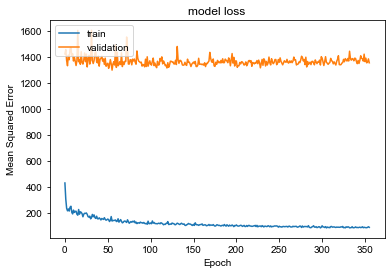

In [21]:
plot_the_loss_curve(epochs,history)

In [22]:
from sklearn.metrics import r2_score
print('Test R^2: ',r2_score(y_test, y_pred_test))
print('Train R^2: ',r2_score(y_train, best_model.predict(X_train)))

Test R^2:  0.8934541719491313
Train R^2:  0.9752275551556899


In [23]:
from sklearn.metrics import mean_squared_error
rms_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("Test RMSE: ", rms_test)

Test RMSE:  36.27037


In [24]:
score = best_model.evaluate(X_test,y_test, verbose=0)[1]
print("Test loss: ",score)

Test loss:  1315.5396728515625


<module 'matplotlib.pyplot' from 'C:\\Users\\Marco\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

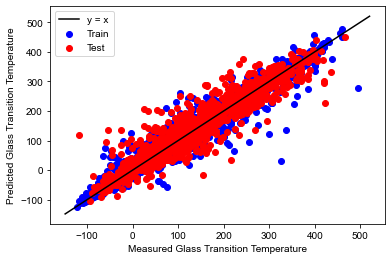

In [25]:
plotNNpredictor(X_train,X_test,y_train,y_test)

In [26]:
y_train_gt1 = y_train
y_train_pred_gt1 = best_model.predict(X_train)
y_test_gt1 = y_test
y_test_pred_gt1 = y_pred_test

### k-Fold Cross-validation

In [27]:
#Define Number of Folds
num_folds = 5

# Define per-fold score containers
r2_per_fold = []
mse_per_fold = []         #This is defined in the model as metrics=[keras.metrics.MeanSquaredError()]
loss_per_fold = []        #This is defined in the model as loss="mean_squared_error"

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):

    model = tuner.hypermodel.build(best_hps)    #Use our already tuned model
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X[train], y[train],
              epochs=400,
              verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    r2_per_fold.append(r2_score(y[test], model.predict(X[test])))
    mse_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(mse_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - R^2: {r2_per_fold[i]} - Loss: {loss_per_fold[i]} - MSE: {mse_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Test R^2: {np.mean(r2_per_fold)} \u00B1 {np.std(r2_per_fold)}')
print(f'> MSE: {np.mean(mse_per_fold)} \u00B1 {np.std(mse_per_fold)}')
print(f'> Loss: {np.mean(loss_per_fold)} \u00B1 {np.std(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1269.8262939453125; mean_squared_error of 1250.38818359375
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 1531.5428466796875; mean_squared_error of 1511.7261962890625
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 1287.7548828125; mean_squared_error of 1268.0986328125
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 1364.0596923828125; mean_squared_error of 1343.44287109375
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 1325.9952392578125; mean_squared_error of 1306.32275390625
------------------------------------------------------------------------
Score per fold
----

# Density

In [12]:
df = nims3

In [13]:
df.head()

,PID,Name,Molfile,SMILES,Density
0,P010001,polyethene,P010001.mol,*C*,0.9362
1,P010002,poly(prop-1-ene),P010002.mol,*CC(*)C,0.9031
2,P010003,poly(but-1-ene),P010003.mol,*CC(*)CC,0.9
3,P010004,poly(pent-1-ene),P010004.mol,*CC(*)CCC,0.9
4,P010006,poly(3-methylbut-1-ene),P010006.mol,*CC(*)C(C)C,0.906


In [14]:
#Generate a new dataframe with only Smiles, Fingerprints, Monomer weight, Solubility Parameter, and Glass Transition Temperature
#Since this is an old NIMS file, we have to take the average column for each desired property.

mol_list = []
for i in range(len(df.SMILES)):
    try:
        element = df.SMILES[i]
        indexed = []
        mol = Chem.MolFromSmiles(str(element)) #Use RDKit to get mol objects from the SMILES strings
        mw = Chem.Descriptors.ExactMolWt(mol) #Get the monomer weight from the mol objects
        indexed.append(i)
        indexed.append(element)
        indexed.append(mol)
        indexed.append(mw)
        indexed.append(df['Density'][i])
        mol_list.append(indexed)
    except:
        pass

FP_list = []
numpyarrays = []

#Create Columns for Fingerprints and FPs as Numpy arrays. The arrays are easier to feed to the NN.
i = 0
baseData = np.arange(1,1)
for mol in mol_list:
    arr = np.zeros((1,))
    try:
        FP = Chem.RDKFingerprint(mol[2])
        FP_list.append(FP)
        DataStructs.ConvertToNumpyArray(FP, arr)
        numpyarrays.append(arr)
        row = np.array([mol[0], mol[1], FP, arr, mol[3],mol[4]], dtype = object)
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1 
    except:
        i = i+1
        pass

columnNames=["Index", "SMILES","RDKit FingerPrint","FP as Numpy array","Monomer_Weight","Density"]
df = pd.DataFrame(data=baseData,columns=columnNames)

In [15]:
df

,Index,SMILES,RDKit FingerPrint,FP as Numpy array,Monomer_Weight,Density
0,0,*C*,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.0157,0.9362
1,1,*CC(*)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",42.047,0.9031
2,2,*CC(*)CC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56.0626,0.9
3,3,*CC(*)CCC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",70.0783,0.9
4,4,*CC(*)C(C)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",70.0783,0.906
...,...,...,...,...,...,...
1673,1673,*CC(*)(F)C(=O)OCC(F)(F)F,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",172.015,1.5868
1674,1674,*CC(*)(F)C(=O)OCC(F)(F)C(F)(F)F,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",222.012,1.654
1675,1675,*CC(*)(F)C(=O)OCC(F)(F)C(F)F,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",204.021,1.6447
1676,1676,*CC(*)(F)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)F,"[0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, ...",304.015,1.7588


In [16]:
#Remove rows with Tg values that cannot be converted to floats
index_names = []
for i in range(len(df['Density'])):
    try:
        np.array(df.iloc[i]['Density']).astype('float32')
    except:
        index_names.append(i)

df.drop(index=index_names, inplace = True)

In [17]:
#Convert values to numpy float arrays
Monomer_Weight = np.array(df['Monomer_Weight'].values).astype('float32')
Density = np.array(df['Density'].values).astype('float32')

props = np.hstack((Monomer_Weight[:,None], Density[:,None]))

df_props = pd.DataFrame(data=props,columns=['Monomer_Weight','Density'])
df_props

,Monomer_Weight,Density
0,14.015650,0.9362
1,42.046951,0.9031
2,56.062599,0.9000
3,70.078247,0.9000
4,70.078247,0.9060
...,...,...
1647,172.014740,1.5868
1648,222.011551,1.6540
1649,204.020966,1.6447
1650,304.014587,1.7588


## Distribution Plots

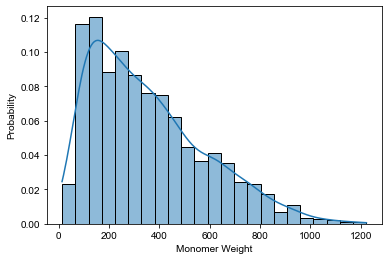

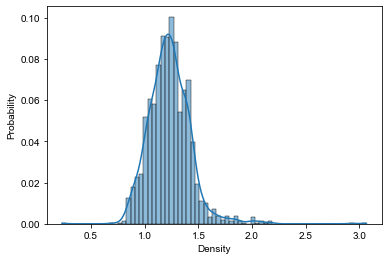

In [33]:
#Distribution Plot for monomer weight
dp = sns.histplot(x='Monomer_Weight',data=df_props, stat='probability', kde = True)
dp.set(xlabel='Monomer Weight')
plt.rcParams.update({'font.family':'Arial'})
plt.show()

#Distribution Plot for glass transition temperature
dp = sns.histplot(x='Density',data=df_props, stat ='probability', kde = True)
dp.set(xlabel='Density')
plt.rcParams.update({'font.family':'Arial'})
plt.show()

#plt.savefig('Monomer_weight_dist.png')
#plt.savefig('Sol_Param_dist.png')
#plt.savefig('Glass_Trans_dist.png')

# Keras Tuner

Below shows the code defining the deep neural network model, which has most hyperparameters chosen through Keras Tuner, a method similar to Scikit Learn's GridSearchCV(). Essentially the model starts being built by defining an input layer, which is a layer that takes in an expected tensor shape. The tensor at hand is defined by our feature vector, which in this case is a 2049-component vector. Each feature vector is individually fed into the model, so our input is really 1-dimensional, and each component of the feature vector has its own node. After this we define 3 hidden layers, which are fully connected to the layer before and after. By fully connected, it is meant that every node in the layer is connected to every node in the layer before and after. Lastly there is a final layer that only has one node, which outputs a single value, in this case being a property (glass transition temperature, solubility temperature, etc.).

The tuner works by taking multiple 'choice' parameters defined throughout the model, and running multiple variations of these parameters in the form of different models. Instead of fully running the different models, only a short sample of data is trained and tested. The tuner saves the data of all of these different model runs on your local machine and when finished going through all of the different combinations of parameters, will choose the model with the smallest validation loss (or whatever else you choose under the objective argument in kt.Hyperband() which initiates the search). This means that when there are many different values for each parameter that you would like to search for, the number of combinations dramatically increases, and the time to find the best model will also increase.

In the model below, choices are made for the tuner to search through:
- l2 or l1 regularization (this will be set at every hidden layer)
    - regularization rate: search between directly defined values
- Number of nodes in each hidden layer
    - search between a minimum and maximum number of nodes with a step size
- Dropout rate between each hidden layer
    - dropout allows for random removal of nodes during training to minimize overfitting
- Learning rate: search between directly defined values

In [34]:
#Wrapper for regulaization, will allow tuner to choose best regularization and value
def reg_wrapper(type, value):
    if type == 'l2':
        return keras.regularizers.l2(value)
    if type == 'l1':
        return keras.regularizers.l1(value)

def build_model(hp):
    reg = reg_wrapper(hp.Choice('type', ['l1', 'l2']), hp.Choice('reg_value', values=[0.01,0.001,0.1,0.005,0.05]))
    
    # Most simple tf.keras models are sequential.
    model = keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    # Describe the topography of the model. 

    # Implement L2 regularization in the first hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units1", min_value=16, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden1'))
    #add Dropout under first hidden layer
    model.add(keras.layers.Dropout(hp.Choice("Dropout_rate1", values=[0.0,0.1,0.2,0.3,0.4,0.5])))
    
    # Implement L2 regularization in the second hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units2", min_value=16, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden2'))
    #add Dropout under second hidden layer
    model.add(keras.layers.Dropout(hp.Choice("Dropout_rate2", values=[0.0,0.1,0.2,0.3,0.4,0.5])))
    
    # Implement L2 regularization in the third hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units3", min_value=16, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden3'))
    
    #no dropout layer added before the output layer. 
    
    # Define the output layer.
    model.add(keras.layers.Dense(units=1,
                                  activation='linear',
                                  name='Output',
                                  ))                              

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-1,1e-2,1e-3,1e-4])),
        loss="mean_squared_error",
        metrics=[keras.metrics.MeanSquaredError()]
    )

    return model 

In [35]:
df_D = df.dropna(subset=['Density'])

X1 = np.array(list(df_D['FP as Numpy array'].values)).astype('float64')
X2 = np.array([list(df_D['Monomer_Weight'].values)]).astype('float64')
X2=X2.T #Transpose array to line up with X1

#Standard Normalization (Z-score)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X2)
X2 = scaler.transform(X2)

X = np.concatenate((X1, X2), axis=1)

y = np.array(df_D['Density'].values).astype('float32')

input_shape = X.shape[1]

In [36]:
print(X.shape)

(1623, 2049)


In [37]:
#Partitioning the Monomer Weight data into an 80/20 train/validation split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [38]:
tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=300,
    directory=os.path.normpath(r'C:\Users\Marco\Documents'),
    project_name = "Final_Report_Density"
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2,shuffle=True)

INFO:tensorflow:Reloading Oracle from existing project C:\Users\Marco\Documents\Final_Report_Density\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Marco\Documents\Final_Report_Density\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [39]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate'] + ['type'] + ['reg_value'] + ['Dropout_rate1'] + ['Dropout_rate2']:
    print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

units1 480
units2 240
units3 288
learning_rate 0.0001
type l2
reg_value 0.001
Dropout_rate1 0.1
Dropout_rate2 0.1


In [40]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden1 (Dense)              (None, 480)               984000    
_________________________________________________________________
dropout (Dropout)            (None, 480)               0         
_________________________________________________________________
Hidden2 (Dense)              (None, 240)               115440    
_________________________________________________________________
dropout_1 (Dropout)          (None, 240)               0         
_________________________________________________________________
Hidden3 (Dense)              (None, 288)               69408     
_________________________________________________________________
Output (Dense)               (None, 1)                 289       
Total params: 1,169,137
Trainable params: 1,169,137
Non-trainable params: 0
______________________________________________

In [41]:
#Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)

#Train Model
history = best_model.fit(
    X_train, 
    y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=10,
    shuffle=True,
    callbacks=[es]
)

#Get number of Epochs after early stoppage
epochs = history.epoch

# Model prediction against the test set.
y_pred_test = best_model.predict(X_test)

Epoch 1/1000
104/104 [==============================] - 1s 7ms/step - loss: 0.0101 - mean_squared_error: 0.0064 - val_loss: 0.0141 - val_mean_squared_error: 0.0096
Epoch 2/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0096 - mean_squared_error: 0.0051 - val_loss: 0.0113 - val_mean_squared_error: 0.0069
Epoch 3/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0086 - mean_squared_error: 0.0041 - val_loss: 0.0114 - val_mean_squared_error: 0.0070
Epoch 4/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0077 - mean_squared_error: 0.0035 - val_loss: 0.0111 - val_mean_squared_error: 0.0068
Epoch 5/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0067 - mean_squared_error: 0.0026 - val_loss: 0.0121 - val_mean_squared_error: 0.0079
Epoch 6/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0065 - mean_squared_error: 0.0025 - val_loss: 0.0106 - val_mean_squared_error: 0.0067
Epoch 7/1000
104

Epoch 51/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0053 - mean_squared_error: 0.0021 - val_loss: 0.0096 - val_mean_squared_error: 0.0065
Epoch 52/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0053 - mean_squared_error: 0.0022 - val_loss: 0.0101 - val_mean_squared_error: 0.0069
Epoch 53/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0051 - mean_squared_error: 0.0020 - val_loss: 0.0097 - val_mean_squared_error: 0.0067
Epoch 54/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0052 - mean_squared_error: 0.0021 - val_loss: 0.0098 - val_mean_squared_error: 0.0068
Epoch 55/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0059 - mean_squared_error: 0.0028 - val_loss: 0.0113 - val_mean_squared_error: 0.0082
Epoch 56/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0052 - mean_squared_error: 0.0021 - val_loss: 0.0103 - val_mean_squared_error: 0.0073
Epoch 57/1

104/104 [==============================] - 1s 6ms/step - loss: 0.0048 - mean_squared_error: 0.0021 - val_loss: 0.0100 - val_mean_squared_error: 0.0072
Epoch 150/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0047 - mean_squared_error: 0.0019 - val_loss: 0.0106 - val_mean_squared_error: 0.0078
Epoch 151/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0046 - mean_squared_error: 0.0018 - val_loss: 0.0102 - val_mean_squared_error: 0.0075
Epoch 152/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0046 - mean_squared_error: 0.0019 - val_loss: 0.0112 - val_mean_squared_error: 0.0084
Epoch 153/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0046 - mean_squared_error: 0.0019 - val_loss: 0.0091 - val_mean_squared_error: 0.0064
Epoch 154/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0017 - val_loss: 0.0093 - val_mean_squared_error: 0.0066
Epoch 155/1000
104/

104/104 [==============================] - 1s 6ms/step - loss: 0.0043 - mean_squared_error: 0.0017 - val_loss: 0.0097 - val_mean_squared_error: 0.0070
Epoch 248/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0013 - val_loss: 0.0093 - val_mean_squared_error: 0.0067
Epoch 249/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0018 - val_loss: 0.0096 - val_mean_squared_error: 0.0070
Epoch 250/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0051 - mean_squared_error: 0.0025 - val_loss: 0.0093 - val_mean_squared_error: 0.0066
Epoch 251/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0049 - mean_squared_error: 0.0023 - val_loss: 0.0095 - val_mean_squared_error: 0.0070
Epoch 252/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0051 - mean_squared_error: 0.0024 - val_loss: 0.0095 - val_mean_squared_error: 0.0068
Epoch 253/1000
104/

104/104 [==============================] - 1s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0017 - val_loss: 0.0096 - val_mean_squared_error: 0.0071
Epoch 346/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0043 - mean_squared_error: 0.0019 - val_loss: 0.0100 - val_mean_squared_error: 0.0075
Epoch 347/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0046 - mean_squared_error: 0.0020 - val_loss: 0.0096 - val_mean_squared_error: 0.0071
Epoch 348/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0045 - mean_squared_error: 0.0020 - val_loss: 0.0097 - val_mean_squared_error: 0.0072
Epoch 349/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0043 - mean_squared_error: 0.0018 - val_loss: 0.0094 - val_mean_squared_error: 0.0070
Epoch 350/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0016 - val_loss: 0.0092 - val_mean_squared_error: 0.0067
Epoch 351/1000
104/

104/104 [==============================] - 1s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0017 - val_loss: 0.0092 - val_mean_squared_error: 0.0068
Epoch 444/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0016 - val_loss: 0.0092 - val_mean_squared_error: 0.0068
Epoch 445/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0042 - mean_squared_error: 0.0018 - val_loss: 0.0092 - val_mean_squared_error: 0.0068
Epoch 446/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0017 - val_loss: 0.0088 - val_mean_squared_error: 0.0064
Epoch 447/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0018 - val_loss: 0.0101 - val_mean_squared_error: 0.0077
Epoch 448/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0042 - mean_squared_error: 0.0018 - val_loss: 0.0090 - val_mean_squared_error: 0.0067
Epoch 449/1000
104/

104/104 [==============================] - 1s 6ms/step - loss: 0.0042 - mean_squared_error: 0.0019 - val_loss: 0.0092 - val_mean_squared_error: 0.0068
Epoch 542/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0042 - mean_squared_error: 0.0018 - val_loss: 0.0089 - val_mean_squared_error: 0.0065
Epoch 543/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0017 - val_loss: 0.0090 - val_mean_squared_error: 0.0067
Epoch 544/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0018 - val_loss: 0.0089 - val_mean_squared_error: 0.0066
Epoch 545/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0021 - val_loss: 0.0093 - val_mean_squared_error: 0.0069
Epoch 546/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0018 - val_loss: 0.0086 - val_mean_squared_error: 0.0064
Epoch 547/1000
104/

104/104 [==============================] - 1s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0019 - val_loss: 0.0093 - val_mean_squared_error: 0.0071
Epoch 640/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0038 - mean_squared_error: 0.0016 - val_loss: 0.0093 - val_mean_squared_error: 0.0070
Epoch 641/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0019 - val_loss: 0.0093 - val_mean_squared_error: 0.0070
Epoch 642/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0018 - val_loss: 0.0088 - val_mean_squared_error: 0.0067
Epoch 643/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0017 - val_loss: 0.0086 - val_mean_squared_error: 0.0064
Epoch 644/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0017 - val_loss: 0.0092 - val_mean_squared_error: 0.0070
Epoch 645/1000
104/

104/104 [==============================] - 1s 6ms/step - loss: 0.0042 - mean_squared_error: 0.0020 - val_loss: 0.0092 - val_mean_squared_error: 0.0070
Epoch 738/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0018 - val_loss: 0.0085 - val_mean_squared_error: 0.0063
Epoch 739/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0038 - mean_squared_error: 0.0016 - val_loss: 0.0087 - val_mean_squared_error: 0.0065
Epoch 740/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0016 - val_loss: 0.0088 - val_mean_squared_error: 0.0067
Epoch 741/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0020 - val_loss: 0.0088 - val_mean_squared_error: 0.0067
Epoch 742/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0017 - val_loss: 0.0087 - val_mean_squared_error: 0.0066
Epoch 743/1000
104/

104/104 [==============================] - 1s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0016 - val_loss: 0.0089 - val_mean_squared_error: 0.0067
Epoch 836/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0017 - val_loss: 0.0083 - val_mean_squared_error: 0.0062
Epoch 837/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0018 - val_loss: 0.0092 - val_mean_squared_error: 0.0070
Epoch 838/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0043 - mean_squared_error: 0.0022 - val_loss: 0.0087 - val_mean_squared_error: 0.0065
Epoch 839/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0042 - mean_squared_error: 0.0020 - val_loss: 0.0090 - val_mean_squared_error: 0.0068
Epoch 840/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0016 - val_loss: 0.0090 - val_mean_squared_error: 0.0069
Epoch 841/1000
104/

104/104 [==============================] - 1s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0018 - val_loss: 0.0093 - val_mean_squared_error: 0.0072
Epoch 934/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0038 - mean_squared_error: 0.0017 - val_loss: 0.0088 - val_mean_squared_error: 0.0068
Epoch 935/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0016 - val_loss: 0.0089 - val_mean_squared_error: 0.0069
Epoch 936/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0038 - mean_squared_error: 0.0017 - val_loss: 0.0092 - val_mean_squared_error: 0.0071
Epoch 937/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0020 - val_loss: 0.0091 - val_mean_squared_error: 0.0070
Epoch 938/1000
104/104 [==============================] - 1s 6ms/step - loss: 0.0036 - mean_squared_error: 0.0016 - val_loss: 0.0092 - val_mean_squared_error: 0.0072
Epoch 939/1000
104/

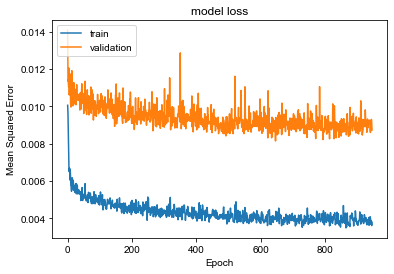

In [42]:
plot_the_loss_curve(epochs,history)

In [43]:
from sklearn.metrics import r2_score
print('Test R^2: ',r2_score(y_test, y_pred_test))
print('Train R^2: ',r2_score(y_train, best_model.predict(X_train)))

Test R^2:  0.7354645878579875
Train R^2:  0.9476879870329695


In [44]:
from sklearn.metrics import mean_squared_error
rms_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("Test RMSE: ", rms_test)

Test RMSE:  0.10510592


In [45]:
score = best_model.evaluate(X_test,y_test, verbose=0)[1]
print("Test loss: ",score)

Test loss:  0.01104725431650877


In [46]:
def plotNNpredictor(X_train,X_test,y_train,y_test):
    plt.rcParams.update({'font.family':'Arial'})
    plt.scatter(y_train,best_model.predict(X_train), label = 'Train', c='blue',edgecolors='black')
    #plt.title('Neural Network Predictor')
    plt.xlabel('Measured Density')
    plt.ylabel('Predicted Density')
    plt.scatter(y_test,best_model.predict(X_test),c='red',edgecolors='black', label='Test')
    plt.plot([y_train.min(),y_train.max()], [y_train.min(),y_train.max()], color = 'black', label = 'y = x')
    plt.legend(loc=0)
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Marco\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

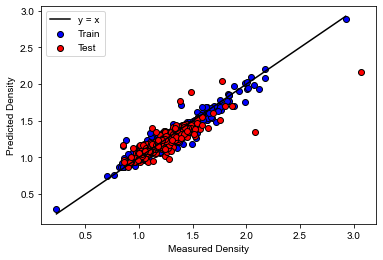

In [47]:
plotNNpredictor(X_train,X_test,y_train,y_test)

In [48]:
y_train_d1 = y_train
y_train_pred_d1 = best_model.predict(X_train)
y_test_d1 = y_test
y_test_pred_d1 = y_pred_test

### k-Fold Cross-validation

In [49]:
#Define Number of Folds
num_folds = 5

# Define per-fold score containers
r2_per_fold = []
mse_per_fold = []         #This is defined in the model as metrics=[keras.metrics.MeanSquaredError()]
loss_per_fold = []        #This is defined in the model as loss="mean_squared_error"

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):

    model = tuner.hypermodel.build(best_hps)    #Use our already tuned model
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X[train], y[train],
              epochs=1000,
              verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    r2_per_fold.append(r2_score(y[test], model.predict(X[test])))
    mse_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(mse_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - R^2: {r2_per_fold[i]} - Loss: {loss_per_fold[i]} - MSE: {mse_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Test R^2: {np.mean(r2_per_fold)} \u00B1 {np.std(r2_per_fold)}')
print(f'> MSE: {np.mean(mse_per_fold)} \u00B1 {np.std(mse_per_fold)}')
print(f'> Loss: {np.mean(loss_per_fold)} \u00B1 {np.std(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.014477330259978771; mean_squared_error of 0.012168877758085728
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.008296889252960682; mean_squared_error of 0.006010598037391901
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.01688084751367569; mean_squared_error of 0.014719001948833466
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.014445597305893898; mean_squared_error of 0.012122158892452717
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.01678421162068844; mean_squared_error of 0.014662625268101692
--------------------------------------------------------------

# Solubility Parameter

In [26]:
df = nims4

In [27]:
df.head()

,PID,Name,Molfile,SMILES,Solubility parameter
0,P010001,polyethene,P010001.mol,*C*,16.4
1,P010002,poly(prop-1-ene),P010002.mol,*CC(*)C,17.56555555555556
2,P010003,poly(but-1-ene),P010003.mol,*CC(*)CC,15.66
3,P010008,poly(4-methylpent-1-ene),P010008.mol,*CC(*)CC(C)C,17.740000000000002
4,P010014,poly(2-methylprop-1-ene),P010014.mol,*CC(*)(C)C,16.2


In [28]:
#Generate a new dataframe with only Smiles, Fingerprints, Monomer weight, Solubility Parameter, and Glass Transition Temperature
#Since this is an old NIMS file, we have to take the average column for each desired property.

mol_list = []
for i in range(len(df.SMILES)):
    try:
        element = df.SMILES[i]
        indexed = []
        mol = Chem.MolFromSmiles(str(element)) #Use RDKit to get mol objects from the SMILES strings
        mw = Chem.Descriptors.ExactMolWt(mol) #Get the monomer weight from the mol objects
        indexed.append(i)
        indexed.append(element)
        indexed.append(mol)
        indexed.append(mw)
        indexed.append(df['Solubility parameter'][i])
        mol_list.append(indexed)
    except:
        pass


FP_list = []
numpyarrays = []

#Create Columns for Fingerprints and FPs as Numpy arrays. The arrays are easier to feed to the NN.
i = 0
baseData = np.arange(1,1)
for mol in mol_list:
    arr = np.zeros((1,))
    try:
        FP = Chem.RDKFingerprint(mol[2])
        FP_list.append(FP)
        DataStructs.ConvertToNumpyArray(FP, arr)
        numpyarrays.append(arr)
        row = np.array([mol[0], mol[1], FP, arr, mol[3],mol[4]], dtype = object)
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1 
    except:
        i = i+1
        pass

columnNames=["Index", "SMILES","RDKit FingerPrint","FP as Numpy array","Monomer_Weight","Solubility_Parameter"]
df = pd.DataFrame(data=baseData,columns=columnNames)

In [29]:
df

,Index,SMILES,RDKit FingerPrint,FP as Numpy array,Monomer_Weight,Solubility_Parameter
0,0,*C*,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.0157,16.4
1,1,*CC(*)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",42.047,17.56555555555556
2,2,*CC(*)CC,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56.0626,15.66
3,3,*CC(*)CC(C)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",84.0939,17.740000000000002
4,4,*CC(*)(C)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56.0626,16.2
...,...,...,...,...,...,...
311,311,*CCCOC(=O)O*,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",102.032,20
312,312,*Nc1ccc(*)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",91.0422,21.8
313,313,*c1cccc(-c2nc3cc(-c4ccc5[nH]c(*)nc5c4)ccc3[nH...,"[1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, ...","[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...",308.106,26.8
314,314,*O[Si](*)(C)CCC#N,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",113.03,18


In [30]:
#Remove rows with Tg values that cannot be converted to floats
index_names = []
for i in range(len(df['Solubility_Parameter'])):
    try:
        np.array(df.iloc[i]['Solubility_Parameter']).astype('float32')
    except:
        index_names.append(i)

df.drop(index=index_names, inplace = True)

In [31]:
#Convert values to numpy float arrays
Monomer_Weight = np.array(df['Monomer_Weight'].values).astype('float32')
Solubility_Parameter = np.array(df['Solubility_Parameter'].values).astype('float32')

props = np.hstack((Monomer_Weight[:,None], Density[:,None]))

df_props = pd.DataFrame(data=props,columns=['Monomer_Weight','Solubility_Parameter'])
df_props

,Monomer_Weight,Solubility_Parameter
0,14.015650,16.400000
1,42.046951,17.565556
2,56.062599,15.660000
3,84.093903,17.740000
4,56.062599,16.200001
...,...,...
306,102.031693,20.000000
307,91.042198,21.799999
308,308.106201,26.799999
309,113.029694,18.000000


## Distribution Plots

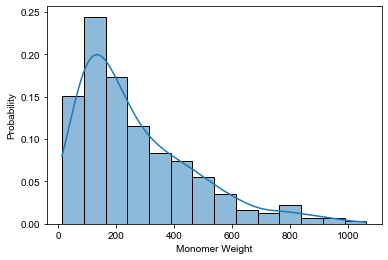

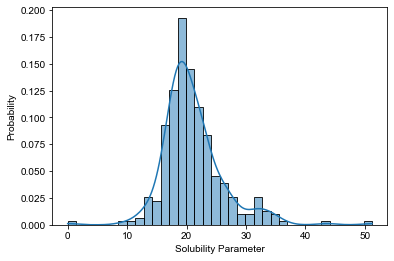

In [55]:
#Distribution Plot for monomer weight
dp = sns.histplot(x='Monomer_Weight',data=df_props, stat='probability', kde = True)
dp.set(xlabel='Monomer Weight')
plt.rcParams.update({'font.family':'Arial'})
plt.show()

#Distribution Plot for glass transition temperature
dp = sns.histplot(x='Solubility_Parameter',data=df_props, stat ='probability', kde = True)
dp.set(xlabel='Solubility Parameter')
plt.rcParams.update({'font.family':'Arial'})
plt.show()

#plt.savefig('Monomer_weight_dist.png')
#plt.savefig('Sol_Param_dist.png')
#plt.savefig('Glass_Trans_dist.png')

# Keras Tuner

Below shows the code defining the deep neural network model, which has most hyperparameters chosen through Keras Tuner, a method similar to Scikit Learn's GridSearchCV(). Essentially the model starts being built by defining an input layer, which is a layer that takes in an expected tensor shape. The tensor at hand is defined by our feature vector, which in this case is a 2049-component vector. Each feature vector is individually fed into the model, so our input is really 1-dimensional, and each component of the feature vector has its own node. After this we define 3 hidden layers, which are fully connected to the layer before and after. By fully connected, it is meant that every node in the layer is connected to every node in the layer before and after. Lastly there is a final layer that only has one node, which outputs a single value, in this case being a property (glass transition temperature, solubility temperature, etc.).

The tuner works by taking multiple 'choice' parameters defined throughout the model, and running multiple variations of these parameters in the form of different models. Instead of fully running the different models, only a short sample of data is trained and tested. The tuner saves the data of all of these different model runs on your local machine and when finished going through all of the different combinations of parameters, will choose the model with the smallest validation loss (or whatever else you choose under the objective argument in kt.Hyperband() which initiates the search). This means that when there are many different values for each parameter that you would like to search for, the number of combinations dramatically increases, and the time to find the best model will also increase.

In the model below, choices are made for the tuner to search through:
- l2 or l1 regularization (this will be set at every hidden layer)
    - regularization rate: search between directly defined values
- Number of nodes in each hidden layer
    - search between a minimum and maximum number of nodes with a step size
- Dropout rate between each hidden layer
    - dropout allows for random removal of nodes during training to minimize overfitting
- Learning rate: search between directly defined values

In [56]:
#Wrapper for regulaization, will allow tuner to choose best regularization and value
def reg_wrapper(type, value):
    if type == 'l2':
        return keras.regularizers.l2(value)
    if type == 'l1':
        return keras.regularizers.l1(value)

def build_model(hp):
    reg = reg_wrapper(hp.Choice('type', ['l1', 'l2']), hp.Choice('reg_value', values=[0.01,0.001,0.1,0.005,0.05]))
    
    # Most simple tf.keras models are sequential.
    model = keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    # Describe the topography of the model. 

    # Implement L2 regularization in the first hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units1", min_value=0, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden1'))
#     #add Dropout under first hidden layer
#     model.add(keras.layers.Dropout(hp.Choice("Dropout_rate1", values=[0.0,0.1,0.2,0.3,0.4,0.5])))
    
    # Implement L2 regularization in the second hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units2", min_value=0, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden2'))
#     #add Dropout under second hidden layer
#     model.add(keras.layers.Dropout(hp.Choice("Dropout_rate2", values=[0.0,0.1,0.2,0.3,0.4,0.5])))
    
    # Implement L2 regularization in the third hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units3", min_value=0, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden3'))
    
    #no dropout layer added before the output layer. 
    
    # Define the output layer.
    model.add(keras.layers.Dense(units=1,
                                  activation='linear',
                                  name='Output',
                                  ))                              

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-1,1e-2,1e-3,1e-4])),
        loss="mean_squared_error",
        metrics=[keras.metrics.MeanSquaredError()]
    )

    return model 

In [57]:
df_SP = df.dropna(subset=['Solubility_Parameter'])

X1 = np.array(list(df_SP['FP as Numpy array'].values)).astype('float64')
X2 = np.array([list(df_SP['Monomer_Weight'].values)]).astype('float64')
X2=X2.T #Transpose array to line up with X1

#Standard Normalization (Z-score)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X2)
X2 = scaler.transform(X2)

X = np.concatenate((X1, X2), axis=1)

y = np.array(df_SP['Solubility_Parameter'].values).astype('float32')

input_shape = X.shape[1]

In [58]:
print(X.shape)

(311, 2049)


In [59]:
#Partitioning the Monomer Weight data into an 80/20 train/validation split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [60]:
tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=100,
    directory=os.path.normpath(r'C:\Users\Marco\Documents'),
    project_name = "Final_Report_SP"
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2,shuffle=True)

INFO:tensorflow:Reloading Oracle from existing project C:\Users\Marco\Documents\Final_Report_SP\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Marco\Documents\Final_Report_SP\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [61]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate'] + ['type'] + ['reg_value']:
    print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

units1 32
units2 432
units3 224
learning_rate 0.01
type l2
reg_value 0.001


In [62]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden1 (Dense)              (None, 32)                65600     
_________________________________________________________________
Hidden2 (Dense)              (None, 432)               14256     
_________________________________________________________________
Hidden3 (Dense)              (None, 224)               96992     
_________________________________________________________________
Output (Dense)               (None, 1)                 225       
Total params: 177,073
Trainable params: 177,073
Non-trainable params: 0
_________________________________________________________________


In [75]:
#Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)

#Train Model
history = best_model.fit(
    X_train, 
    y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=10,
    shuffle=True,
    callbacks=[es]
)

#Get number of Epochs after early stoppage
epochs = history.epoch

# Model prediction against the test set.
y_pred_test = best_model.predict(X_test)

Epoch 1/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.3379 - mean_squared_error: 2.4331 - val_loss: 19.9400 - val_mean_squared_error: 19.0445
Epoch 2/1000
20/20 [==============================] - 0s 2ms/step - loss: 2.7452 - mean_squared_error: 1.8477 - val_loss: 21.4306 - val_mean_squared_error: 20.5335
Epoch 3/1000
20/20 [==============================] - 0s 2ms/step - loss: 5.4140 - mean_squared_error: 4.5186 - val_loss: 19.2922 - val_mean_squared_error: 18.3954
Epoch 4/1000
20/20 [==============================] - 0s 2ms/step - loss: 5.4531 - mean_squared_error: 4.5556 - val_loss: 17.4011 - val_mean_squared_error: 16.5030
Epoch 5/1000
20/20 [==============================] - 0s 2ms/step - loss: 4.5858 - mean_squared_error: 3.6921 - val_loss: 17.6617 - val_mean_squared_error: 16.7710
Epoch 6/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.5727 - mean_squared_error: 2.6841 - val_loss: 19.2558 - val_mean_squared_error: 18.3659
Epoch 7/1000
20/

Epoch 51/1000
20/20 [==============================] - 0s 2ms/step - loss: 5.0056 - mean_squared_error: 3.9975 - val_loss: 18.3613 - val_mean_squared_error: 17.3508
Epoch 52/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.7507 - mean_squared_error: 2.7393 - val_loss: 17.9576 - val_mean_squared_error: 16.9489
Epoch 53/1000
20/20 [==============================] - 0s 2ms/step - loss: 2.9356 - mean_squared_error: 1.9303 - val_loss: 20.1650 - val_mean_squared_error: 19.1633
Epoch 54/1000
20/20 [==============================] - 0s 2ms/step - loss: 4.0768 - mean_squared_error: 3.0752 - val_loss: 20.6040 - val_mean_squared_error: 19.6029
Epoch 55/1000
20/20 [==============================] - 0s 2ms/step - loss: 4.3810 - mean_squared_error: 3.3807 - val_loss: 18.2919 - val_mean_squared_error: 17.2929
Epoch 56/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.4561 - mean_squared_error: 2.4560 - val_loss: 19.0813 - val_mean_squared_error: 18.0832
Epoch 57/1

Epoch 101/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.2699 - mean_squared_error: 2.3230 - val_loss: 19.1085 - val_mean_squared_error: 18.1642
Epoch 102/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.1212 - mean_squared_error: 2.1758 - val_loss: 20.7140 - val_mean_squared_error: 19.7672
Epoch 103/1000
20/20 [==============================] - 0s 2ms/step - loss: 2.6260 - mean_squared_error: 1.6836 - val_loss: 21.7996 - val_mean_squared_error: 20.8614
Epoch 104/1000
20/20 [==============================] - 0s 2ms/step - loss: 5.2269 - mean_squared_error: 4.2909 - val_loss: 18.7692 - val_mean_squared_error: 17.8344
Epoch 105/1000
20/20 [==============================] - 0s 2ms/step - loss: 4.8503 - mean_squared_error: 3.9103 - val_loss: 18.0051 - val_mean_squared_error: 17.0636
Epoch 106/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.9345 - mean_squared_error: 2.9942 - val_loss: 19.1347 - val_mean_squared_error: 18.1945
Epoc

20/20 [==============================] - 0s 2ms/step - loss: 5.4744 - mean_squared_error: 4.5648 - val_loss: 21.2769 - val_mean_squared_error: 20.3699
Epoch 200/1000
20/20 [==============================] - 0s 1ms/step - loss: 3.6979 - mean_squared_error: 2.7909 - val_loss: 19.1632 - val_mean_squared_error: 18.2573
Epoch 201/1000
20/20 [==============================] - 0s 1ms/step - loss: 3.3380 - mean_squared_error: 2.4309 - val_loss: 20.5059 - val_mean_squared_error: 19.5942
Epoch 202/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.7048 - mean_squared_error: 2.7963 - val_loss: 21.8828 - val_mean_squared_error: 20.9781
Epoch 203/1000
20/20 [==============================] - 0s 2ms/step - loss: 4.2590 - mean_squared_error: 3.3537 - val_loss: 20.0741 - val_mean_squared_error: 19.1645
Epoch 204/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.7790 - mean_squared_error: 2.8640 - val_loss: 18.9690 - val_mean_squared_error: 18.0541
Epoch 205/1000
20/2

20/20 [==============================] - 0s 2ms/step - loss: 3.2049 - mean_squared_error: 2.2663 - val_loss: 21.9141 - val_mean_squared_error: 20.9779
Epoch 298/1000
20/20 [==============================] - 0s 2ms/step - loss: 2.8394 - mean_squared_error: 1.9017 - val_loss: 22.7065 - val_mean_squared_error: 21.7696
Epoch 299/1000
20/20 [==============================] - 0s 2ms/step - loss: 2.9694 - mean_squared_error: 2.0364 - val_loss: 23.4054 - val_mean_squared_error: 22.4796
Epoch 300/1000
20/20 [==============================] - 0s 2ms/step - loss: 5.2078 - mean_squared_error: 4.2793 - val_loss: 22.5896 - val_mean_squared_error: 21.6564
Epoch 301/1000
20/20 [==============================] - 0s 2ms/step - loss: 4.0461 - mean_squared_error: 3.1084 - val_loss: 19.5649 - val_mean_squared_error: 18.6279
Epoch 302/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.0236 - mean_squared_error: 2.0873 - val_loss: 20.4293 - val_mean_squared_error: 19.4929
Epoch 303/1000
20/2

20/20 [==============================] - 0s 2ms/step - loss: 2.9760 - mean_squared_error: 1.9853 - val_loss: 23.4946 - val_mean_squared_error: 22.5079
Epoch 396/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.0918 - mean_squared_error: 2.1063 - val_loss: 20.2595 - val_mean_squared_error: 19.2759
Epoch 397/1000
20/20 [==============================] - 0s 2ms/step - loss: 4.8130 - mean_squared_error: 3.8301 - val_loss: 18.2836 - val_mean_squared_error: 17.2949
Epoch 398/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.8647 - mean_squared_error: 2.8770 - val_loss: 19.0673 - val_mean_squared_error: 18.0816
Epoch 399/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.1604 - mean_squared_error: 2.1766 - val_loss: 20.6444 - val_mean_squared_error: 19.6643
Epoch 400/1000
20/20 [==============================] - 0s 2ms/step - loss: 2.8160 - mean_squared_error: 1.8362 - val_loss: 23.0146 - val_mean_squared_error: 22.0361
Epoch 401/1000
20/2

20/20 [==============================] - 0s 2ms/step - loss: 2.6145 - mean_squared_error: 1.6856 - val_loss: 21.3483 - val_mean_squared_error: 20.4216
Epoch 494/1000
20/20 [==============================] - 0s 2ms/step - loss: 5.3075 - mean_squared_error: 4.3830 - val_loss: 19.9287 - val_mean_squared_error: 19.0011
Epoch 495/1000
20/20 [==============================] - 0s 2ms/step - loss: 4.2599 - mean_squared_error: 3.3302 - val_loss: 24.3756 - val_mean_squared_error: 23.4429
Epoch 496/1000
20/20 [==============================] - 0s 2ms/step - loss: 4.1678 - mean_squared_error: 3.2354 - val_loss: 23.2013 - val_mean_squared_error: 22.2735
Epoch 497/1000
20/20 [==============================] - 0s 2ms/step - loss: 4.2275 - mean_squared_error: 3.3014 - val_loss: 20.5931 - val_mean_squared_error: 19.6645
Epoch 498/1000
20/20 [==============================] - 0s 2ms/step - loss: 5.3994 - mean_squared_error: 4.4669 - val_loss: 20.8242 - val_mean_squared_error: 19.8843
Epoch 499/1000
20/2

20/20 [==============================] - 0s 2ms/step - loss: 3.9259 - mean_squared_error: 2.9812 - val_loss: 20.9184 - val_mean_squared_error: 19.9736
Epoch 592/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.2048 - mean_squared_error: 2.2594 - val_loss: 18.3798 - val_mean_squared_error: 17.4350
Epoch 593/1000
20/20 [==============================] - 0s 2ms/step - loss: 3.1044 - mean_squared_error: 2.1623 - val_loss: 20.6755 - val_mean_squared_error: 19.7347
Epoch 594/1000
20/20 [==============================] - 0s 2ms/step - loss: 4.3616 - mean_squared_error: 3.4234 - val_loss: 21.9692 - val_mean_squared_error: 21.0285
Epoch 595/1000
20/20 [==============================] - 0s 2ms/step - loss: 4.7334 - mean_squared_error: 3.7893 - val_loss: 18.6750 - val_mean_squared_error: 17.7289
Epoch 596/1000
20/20 [==============================] - 0s 2ms/step - loss: 4.3407 - mean_squared_error: 3.3970 - val_loss: 20.9500 - val_mean_squared_error: 20.0120
Epoch 597/1000
20/2

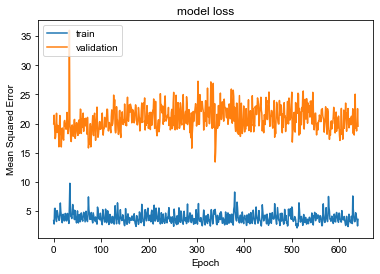

In [81]:
plot_the_loss_curve(epochs,history)

In [82]:
from sklearn.metrics import r2_score
print('Test R^2: ',r2_score(y_test, y_pred_test))
print('Train R^2: ',r2_score(y_train, best_model.predict(X_train)))

Test R^2:  0.2195904752567175
Train R^2:  0.717170551589047


In [83]:
from sklearn.metrics import mean_squared_error
rms_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("Test RMSE: ", rms_test)

Test RMSE:  4.551522


In [84]:
score = best_model.evaluate(X_test,y_test, verbose=0)[1]
print("Test loss: ",score)

Test loss:  20.716350555419922


In [85]:
def plotNNpredictor(X_train,X_test,y_train,y_test):
    plt.rcParams.update({'font.family':'Arial'})
    plt.scatter(y_train,best_model.predict(X_train), label = 'Train', c='blue',edgecolors='black')
    #plt.title('Neural Network Predictor')
    plt.xlabel('Measured Solubility Parameter')
    plt.ylabel('Predicted Solubility Parameter')
    plt.scatter(y_test,best_model.predict(X_test),c='red',edgecolors='black', label='Test')
    plt.plot([y_train.min(),y_train.max()], [y_train.min(),y_train.max()], color = 'black', label = 'y = x')
    plt.legend(loc=0)
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Marco\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

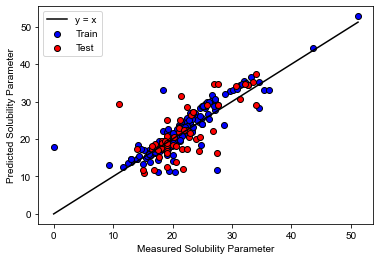

In [86]:
plotNNpredictor(X_train,X_test,y_train,y_test)

In [87]:
y_train_sp1 = y_train
y_train_pred_sp1 = best_model.predict(X_train)
y_test_sp1 = y_test
y_test_pred_sp1 = y_pred_test

### k-Fold Cross-validation

In [71]:
#Define Number of Folds
num_folds = 5

# Define per-fold score containers
r2_per_fold = []
mse_per_fold = []         #This is defined in the model as metrics=[keras.metrics.MeanSquaredError()]
loss_per_fold = []        #This is defined in the model as loss="mean_squared_error"

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):

    model = tuner.hypermodel.build(best_hps)    #Use our already tuned model
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X[train], y[train],
              epochs=700,
              verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    r2_per_fold.append(r2_score(y[test], model.predict(X[test])))
    mse_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(mse_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - R^2: {r2_per_fold[i]} - Loss: {loss_per_fold[i]} - MSE: {mse_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Test R^2: {np.mean(r2_per_fold)} \u00B1 {np.std(r2_per_fold)}')
print(f'> MSE: {np.mean(mse_per_fold)} \u00B1 {np.std(mse_per_fold)}')
print(f'> Loss: {np.mean(loss_per_fold)} \u00B1 {np.std(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 44.765132904052734; mean_squared_error of 44.61496353149414
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 22.650453567504883; mean_squared_error of 22.425729751586914
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 12.053215026855469; mean_squared_error of 11.855409622192383
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 9.125628471374512; mean_squared_error of 8.770177841186523
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 10.790016174316406; mean_squared_error of 10.443163871765137
------------------------------------------------------------------------
Score per 

# Morgan FPs

In [88]:
df = nims2

In [89]:
df.head()

,PID,Name,Molfile,SMILES,Glass transition temp.
0,P010001,polyethene,P010001.mol,*C*,-54
1,P010002,poly(prop-1-ene),P010002.mol,*CC(*)C,-3
2,P010003,poly(but-1-ene),P010003.mol,*CC(*)CC,-24.1
3,P010004,poly(pent-1-ene),P010004.mol,*CC(*)CCC,-37
4,P010006,poly(3-methylbut-1-ene),P010006.mol,*CC(*)C(C)C,56.6667


In [90]:
#Generate a new dataframe with only Smiles, Fingerprints, Monomer weight, Solubility Parameter, and Glass Transition Temperature
#Since this is an old NIMS file, we have to take the average column for each desired property.

mol_list = []
for i in range(len(df.SMILES)):
    try:
        element = df.SMILES[i]
        indexed = []
        mol = Chem.MolFromSmiles(str(element)) #Use RDKit to get mol objects from the SMILES strings
        mw = Chem.Descriptors.ExactMolWt(mol) #Get the monomer weight from the mol objects
        indexed.append(i)
        indexed.append(element)
        indexed.append(mol)
        indexed.append(mw)
        indexed.append(df['Glass transition temp.'][i])
        mol_list.append(indexed)
    except:
        pass

FP_list = []
numpyarrays = []

#Create Columns for Fingerprints and FPs as Numpy arrays. The arrays are easier to feed to the NN.
i = 0
baseData = np.arange(1,1)
for mol in mol_list:
    arr = np.zeros((1,))
    try:
        FP = AllChem.GetMorganFingerprintAsBitVect(mol[2], radius=3, nBits=2048)
        FP_list.append(FP)
        DataStructs.ConvertToNumpyArray(FP, arr)
        numpyarrays.append(arr)
        row = np.array([mol[0], mol[1], FP, arr, mol[3],mol[4]], dtype = object)
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1 
    except:
        i = i+1
        pass

columnNames=["Index", "SMILES","Morgan FingerPrint","FP as Numpy array","Monomer_Weight","Glass_Transition"]
df = pd.DataFrame(data=baseData,columns=columnNames)

In [91]:
df

,Index,SMILES,Morgan FingerPrint,FP as Numpy array,Monomer_Weight,Glass_Transition
0,0,*C*,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.0157,-54
1,1,*CC(*)C,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",42.047,-3
2,2,*CC(*)CC,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56.0626,-24.1
3,3,*CC(*)CCC,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",70.0783,-37
4,4,*CC(*)C(C)C,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",70.0783,56.6667
...,...,...,...,...,...,...
7506,7508,*CC(F)(F)C1(F)C(*)CC(O)(C(F)(F)F)C1(F)F,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",270.029,152
7507,7509,*CC(F)(F)C1(F)CC(CC(O)(C(F)(F)F)C(F)(F)F)CC1*,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",330.067,98
7508,7510,*CC(F)(F)C1(F)CC(C(O)(C(F)(F)F)C(F)(F)F)CC1*,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",316.051,118
7509,7513,*CC(*)(F)C(=O)OCC(Cl)(Cl)Cl,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",219.926,127


In [92]:
#Remove rows with Tg values that cannot be converted to floats
index_names = []
for i in range(len(df['Glass_Transition'])):
    try:
        np.array(df.iloc[i]['Glass_Transition']).astype('float32')
    except:
        index_names.append(i)

df.drop(index=index_names, inplace = True)

In [93]:
#Convert values to numpy float arrays
Monomer_Weight = np.array(df['Monomer_Weight'].values).astype('float32')
Glass_Transition = np.array(df['Glass_Transition'].values).astype('float32')

props = np.hstack((Monomer_Weight[:,None], Glass_Transition[:,None]))

df_props = pd.DataFrame(data=props,columns=['Monomer_Weight','Glass_Transition'])
df_props

,Monomer_Weight,Glass_Transition
0,14.015650,-54.000000
1,42.046951,-3.000000
2,56.062599,-24.100000
3,70.078247,-37.000000
4,70.078247,56.666668
...,...,...
7381,270.029083,152.000000
7382,330.066620,98.000000
7383,316.050964,118.000000
7384,219.926086,127.000000


## Distribution Plots

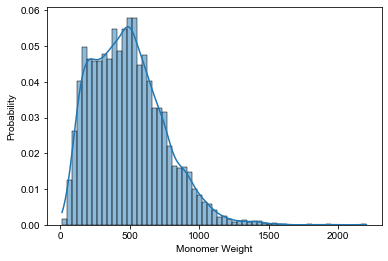

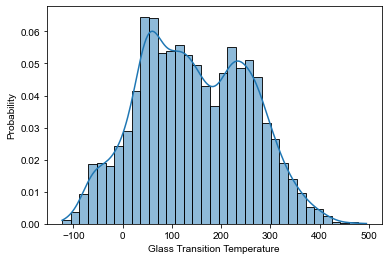

In [94]:
#Distribution Plot for monomer weight
dp = sns.histplot(x='Monomer_Weight',data=df_props, stat='probability', kde = True)
dp.set(xlabel='Monomer Weight')
plt.rcParams.update({'font.family':'Arial'})
plt.show()

#Distribution Plot for glass transition temperature
dp = sns.histplot(x='Glass_Transition',data=df_props, stat ='probability', kde = True)
dp.set(xlabel='Glass Transition Temperature')
plt.rcParams.update({'font.family':'Arial'})
plt.show()

#plt.savefig('Monomer_weight_dist.png')
#plt.savefig('Sol_Param_dist.png')
#plt.savefig('Glass_Trans_dist.png')

# Keras Tuner

Below shows the code defining the deep neural network model, which has most hyperparameters chosen through Keras Tuner, a method similar to Scikit Learn's GridSearchCV(). Essentially the model starts being built by defining an input layer, which is a layer that takes in an expected tensor shape. The tensor at hand is defined by our feature vector, which in this case is a 2049-component vector. Each feature vector is individually fed into the model, so our input is really 1-dimensional, and each component of the feature vector has its own node. After this we define 3 hidden layers, which are fully connected to the layer before and after. By fully connected, it is meant that every node in the layer is connected to every node in the layer before and after. Lastly there is a final layer that only has one node, which outputs a single value, in this case being a property (glass transition temperature, solubility temperature, etc.).

The tuner works by taking multiple 'choice' parameters defined throughout the model, and running multiple variations of these parameters in the form of different models. Instead of fully running the different models, only a short sample of data is trained and tested. The tuner saves the data of all of these different model runs on your local machine and when finished going through all of the different combinations of parameters, will choose the model with the smallest validation loss (or whatever else you choose under the objective argument in kt.Hyperband() which initiates the search). This means that when there are many different values for each parameter that you would like to search for, the number of combinations dramatically increases, and the time to find the best model will also increase.

In the model below, choices are made for the tuner to search through:
- l2 or l1 regularization (this will be set at every hidden layer)
    - regularization rate: search between directly defined values
- Number of nodes in each hidden layer
    - search between a minimum and maximum number of nodes with a step size
- Dropout rate between each hidden layer
    - dropout allows for random removal of nodes during training to minimize overfitting
- Learning rate: search between directly defined values

In [40]:
#!pip install keras-tuner -q
from tensorflow import keras #Even though this was imported more directly up above, import again to avoid errors.
import keras_tuner as kt
import os

In [95]:
#Wrapper for regulaization, will allow tuner to choose best regularization and value
def reg_wrapper(type, value):
    if type == 'l2':
        return keras.regularizers.l2(value)
    if type == 'l1':
        return keras.regularizers.l1(value)

def build_model(hp):
    reg = reg_wrapper(hp.Choice('type', ['l1', 'l2']), hp.Choice('reg_value', values=[0.01,0.001,0.1,0.005,0.05]))
    
    # Most simple tf.keras models are sequential.
    model = keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    # Describe the topography of the model. 

    # Implement L2 regularization in the first hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units1", min_value=16, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden1'))
    #add Dropout under first hidden layer
    model.add(keras.layers.Dropout(hp.Choice("Dropout_rate1", values=[0.0,0.1,0.2,0.3,0.4,0.5])))
    
    # Implement L2 regularization in the second hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units2", min_value=16, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden2'))
    #add Dropout under second hidden layer
    model.add(keras.layers.Dropout(hp.Choice("Dropout_rate2", values=[0.0,0.1,0.2,0.3,0.4,0.5])))
    
    # Implement L2 regularization in the third hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units3", min_value=16, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden3'))
    
    #no dropout layer added before the output layer. 
    
    # Define the output layer.
    model.add(keras.layers.Dense(units=1,
                                  activation='linear',
                                  name='Output',
                                  ))                              

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-1,1e-2,1e-3,1e-4])),
        loss="mean_squared_error",
        metrics=[keras.metrics.MeanSquaredError()]
    )

    return model 

In [96]:
df_GT = df.dropna(subset=['Glass_Transition'])

X1 = np.array(list(df_GT['FP as Numpy array'].values)).astype('float64')
X2 = np.array([list(df_GT['Monomer_Weight'].values)]).astype('float64')
X2=X2.T #Transpose array to line up with X1

#Standard Normalization (Z-score)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X2)
X2 = scaler.transform(X2)

X = np.concatenate((X1, X2), axis=1)

y = np.array(df_GT['Glass_Transition'].values).astype('float32')

input_shape = X.shape[1]

In [97]:
#Partitioning the Monomer Weight data into an 80/20 train/validation split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [98]:
tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=300,
    directory=os.path.normpath(r'C:\Users\Marco\Documents'),
    project_name = "Final_Report_Tg"
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2,shuffle=True)

INFO:tensorflow:Reloading Oracle from existing project C:\Users\Marco\Documents\Final_Report_Tg\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Marco\Documents\Final_Report_Tg\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [99]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate'] + ['type'] + ['reg_value'] + ['Dropout_rate']:
    print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

units1 272
units2 176
units3 336
learning_rate 0.001
type l2
reg_value 0.005
Dropout_rate 0.1


In [100]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden1 (Dense)              (None, 272)               557600    
_________________________________________________________________
dropout (Dropout)            (None, 272)               0         
_________________________________________________________________
Hidden2 (Dense)              (None, 176)               48048     
_________________________________________________________________
dropout_1 (Dropout)          (None, 176)               0         
_________________________________________________________________
Hidden3 (Dense)              (None, 336)               59472     
_________________________________________________________________
Output (Dense)               (None, 1)                 337       
Total params: 665,457
Trainable params: 665,457
Non-trainable params: 0
__________________________________________________

In [101]:
#Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)

#Train Model
history = best_model.fit(
    X_train, 
    y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=10,
    shuffle=True,
    callbacks=[es]
)

#Get number of Epochs after early stoppage
epochs = history.epoch

# Model prediction against the test set.
y_pred_test = best_model.predict(X_test)

Epoch 1/1000
467/467 [==============================] - 2s 3ms/step - loss: 3138.0813 - mean_squared_error: 3112.0581 - val_loss: 1840.2534 - val_mean_squared_error: 1813.4401
Epoch 2/1000
467/467 [==============================] - 1s 3ms/step - loss: 1123.1331 - mean_squared_error: 1095.7999 - val_loss: 1669.3474 - val_mean_squared_error: 1641.5282
Epoch 3/1000
467/467 [==============================] - 1s 3ms/step - loss: 678.7253 - mean_squared_error: 650.4676 - val_loss: 1490.2600 - val_mean_squared_error: 1461.6166
Epoch 4/1000
467/467 [==============================] - 1s 3ms/step - loss: 458.8773 - mean_squared_error: 429.9206 - val_loss: 1486.5911 - val_mean_squared_error: 1457.3303
Epoch 5/1000
467/467 [==============================] - 2s 3ms/step - loss: 349.1984 - mean_squared_error: 319.7765 - val_loss: 1525.8209 - val_mean_squared_error: 1496.1692
Epoch 6/1000
467/467 [==============================] - 2s 3ms/step - loss: 288.8896 - mean_squared_error: 259.1067 - val_loss

Epoch 48/1000
467/467 [==============================] - 2s 3ms/step - loss: 111.5856 - mean_squared_error: 82.7114 - val_loss: 1397.3854 - val_mean_squared_error: 1368.5519
Epoch 49/1000
467/467 [==============================] - 2s 3ms/step - loss: 98.7315 - mean_squared_error: 70.0111 - val_loss: 1386.2922 - val_mean_squared_error: 1357.6223
Epoch 50/1000
467/467 [==============================] - 2s 3ms/step - loss: 106.9897 - mean_squared_error: 78.3786 - val_loss: 1398.9806 - val_mean_squared_error: 1370.4139
Epoch 51/1000
467/467 [==============================] - 2s 3ms/step - loss: 103.7001 - mean_squared_error: 75.2022 - val_loss: 1396.9760 - val_mean_squared_error: 1368.4879
Epoch 52/1000
467/467 [==============================] - 2s 3ms/step - loss: 104.8456 - mean_squared_error: 76.4277 - val_loss: 1384.3228 - val_mean_squared_error: 1355.9681
Epoch 53/1000
467/467 [==============================] - 2s 3ms/step - loss: 102.8133 - mean_squared_error: 74.5400 - val_loss: 140

467/467 [==============================] - 1s 3ms/step - loss: 67.7522 - mean_squared_error: 45.7651 - val_loss: 1370.2886 - val_mean_squared_error: 1348.3018
Epoch 143/1000
467/467 [==============================] - 1s 3ms/step - loss: 66.0259 - mean_squared_error: 44.0886 - val_loss: 1367.7086 - val_mean_squared_error: 1345.7787
Epoch 144/1000
467/467 [==============================] - 1s 3ms/step - loss: 67.7813 - mean_squared_error: 45.8813 - val_loss: 1375.2122 - val_mean_squared_error: 1353.3558
Epoch 145/1000
467/467 [==============================] - 1s 3ms/step - loss: 66.5335 - mean_squared_error: 44.7168 - val_loss: 1396.8109 - val_mean_squared_error: 1374.9967
Epoch 146/1000
467/467 [==============================] - 1s 3ms/step - loss: 69.4831 - mean_squared_error: 47.7207 - val_loss: 1374.6680 - val_mean_squared_error: 1352.9071
Epoch 147/1000
467/467 [==============================] - 1s 3ms/step - loss: 67.9897 - mean_squared_error: 46.2491 - val_loss: 1368.3409 - val_m

Epoch 189/1000
467/467 [==============================] - 2s 3ms/step - loss: 62.8467 - mean_squared_error: 42.6601 - val_loss: 1388.9376 - val_mean_squared_error: 1368.7410
Epoch 190/1000
467/467 [==============================] - 2s 3ms/step - loss: 60.8350 - mean_squared_error: 40.6555 - val_loss: 1385.4148 - val_mean_squared_error: 1365.2559
Epoch 191/1000
467/467 [==============================] - 2s 3ms/step - loss: 60.1227 - mean_squared_error: 39.9852 - val_loss: 1379.2312 - val_mean_squared_error: 1359.1272
Epoch 192/1000
467/467 [==============================] - 2s 3ms/step - loss: 58.0902 - mean_squared_error: 38.0221 - val_loss: 1375.1971 - val_mean_squared_error: 1355.1560
Epoch 193/1000
467/467 [==============================] - 2s 3ms/step - loss: 60.9779 - mean_squared_error: 40.9483 - val_loss: 1393.5463 - val_mean_squared_error: 1373.4829
Epoch 194/1000
467/467 [==============================] - 2s 3ms/step - loss: 60.4278 - mean_squared_error: 40.4281 - val_loss: 13

467/467 [==============================] - 2s 3ms/step - loss: 56.3850 - mean_squared_error: 37.4568 - val_loss: 1389.6744 - val_mean_squared_error: 1370.7371
Epoch 237/1000
467/467 [==============================] - 1s 3ms/step - loss: 55.7790 - mean_squared_error: 36.8720 - val_loss: 1403.6125 - val_mean_squared_error: 1384.7062
Epoch 238/1000
467/467 [==============================] - 2s 3ms/step - loss: 58.8380 - mean_squared_error: 39.9231 - val_loss: 1371.4152 - val_mean_squared_error: 1352.4541
Epoch 239/1000
467/467 [==============================] - 1s 3ms/step - loss: 59.0849 - mean_squared_error: 40.1647 - val_loss: 1387.5515 - val_mean_squared_error: 1368.6498
Epoch 240/1000
467/467 [==============================] - 2s 3ms/step - loss: 57.2132 - mean_squared_error: 38.3292 - val_loss: 1382.2114 - val_mean_squared_error: 1363.2991
Epoch 241/1000
467/467 [==============================] - 1s 3ms/step - loss: 57.2905 - mean_squared_error: 38.3984 - val_loss: 1379.6001 - val_m

467/467 [==============================] - 2s 3ms/step - loss: 52.1588 - mean_squared_error: 34.5896 - val_loss: 1368.0791 - val_mean_squared_error: 1350.5271
Epoch 331/1000
467/467 [==============================] - 2s 3ms/step - loss: 54.2642 - mean_squared_error: 36.6993 - val_loss: 1364.1786 - val_mean_squared_error: 1346.6057
Epoch 332/1000
467/467 [==============================] - 2s 3ms/step - loss: 54.4202 - mean_squared_error: 36.8508 - val_loss: 1377.8195 - val_mean_squared_error: 1360.2437
Epoch 333/1000
467/467 [==============================] - 1s 3ms/step - loss: 53.4765 - mean_squared_error: 35.9117 - val_loss: 1374.8203 - val_mean_squared_error: 1357.2236
Epoch 334/1000
467/467 [==============================] - 2s 3ms/step - loss: 52.0133 - mean_squared_error: 34.4635 - val_loss: 1388.1871 - val_mean_squared_error: 1370.6451
Epoch 335/1000
467/467 [==============================] - 2s 3ms/step - loss: 53.1536 - mean_squared_error: 35.6285 - val_loss: 1369.0757 - val_m

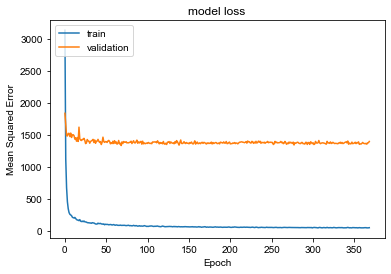

In [102]:
plot_the_loss_curve(epochs,history)

In [103]:
from sklearn.metrics import r2_score
print('Test R^2: ',r2_score(y_test, y_pred_test))
print('Train R^2: ',r2_score(y_train, best_model.predict(X_train)))

Test R^2:  0.9019291212566903
Train R^2:  0.9752762903136086


In [104]:
from sklearn.metrics import mean_squared_error
rms_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("Test RMSE: ", rms_test)

Test RMSE:  34.797962


In [105]:
score = best_model.evaluate(X_test,y_test, verbose=0)[1]
print("Test loss: ",score)

Test loss:  1210.8980712890625


<module 'matplotlib.pyplot' from 'C:\\Users\\Marco\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

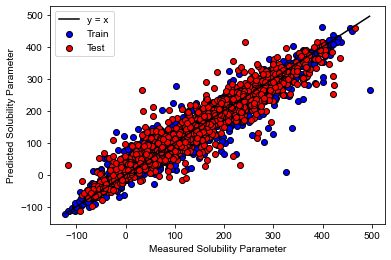

In [106]:
plotNNpredictor(X_train,X_test,y_train,y_test)

In [107]:
y_train_gt2 = y_train
y_train_pred_gt2 = best_model.predict(X_train)
y_test_gt2 = y_test
y_test_pred_gt2 = y_pred_test

### k-Fold Cross-validation

In [54]:
#Define Number of Folds
num_folds = 5

# Define per-fold score containers
r2_per_fold = []
mse_per_fold = []         #This is defined in the model as metrics=[keras.metrics.MeanSquaredError()]
loss_per_fold = []        #This is defined in the model as loss="mean_squared_error"

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):

    model = tuner.hypermodel.build(best_hps)    #Use our already tuned model
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X[train], y[train],
              epochs=400,
              verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    r2_per_fold.append(r2_score(y[test], model.predict(X[test])))
    mse_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(mse_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - R^2: {r2_per_fold[i]} - Loss: {loss_per_fold[i]} - MSE: {mse_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Test R^2: {np.mean(r2_per_fold)} \u00B1 {np.std(r2_per_fold)}')
print(f'> MSE: {np.mean(mse_per_fold)} \u00B1 {np.std(mse_per_fold)}')
print(f'> Loss: {np.mean(loss_per_fold)} \u00B1 {np.std(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 1211.8489990234375; mean_squared_error of 1199.089599609375
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 1262.377197265625; mean_squared_error of 1250.0263671875
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 1298.1331787109375; mean_squared_error of 1285.3519287109375
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 1293.8851318359375; mean_squared_error of 1281.7479248046875
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 1219.46923828125; mean_squared_error of 1206.5802001953125
------------------------------------------------------------------------
Score per fold

# Density

In [108]:
df = nims3

In [109]:
df.head()

,PID,Name,Molfile,SMILES,Density
0,P010001,polyethene,P010001.mol,*C*,0.9362
1,P010002,poly(prop-1-ene),P010002.mol,*CC(*)C,0.9031
2,P010003,poly(but-1-ene),P010003.mol,*CC(*)CC,0.9
3,P010004,poly(pent-1-ene),P010004.mol,*CC(*)CCC,0.9
4,P010006,poly(3-methylbut-1-ene),P010006.mol,*CC(*)C(C)C,0.906


In [110]:
#Generate a new dataframe with only Smiles, Fingerprints, Monomer weight, Solubility Parameter, and Glass Transition Temperature
#Since this is an old NIMS file, we have to take the average column for each desired property.

mol_list = []
for i in range(len(df.SMILES)):
    try:
        element = df.SMILES[i]
        indexed = []
        mol = Chem.MolFromSmiles(str(element)) #Use RDKit to get mol objects from the SMILES strings
        mw = Chem.Descriptors.ExactMolWt(mol) #Get the monomer weight from the mol objects
        indexed.append(i)
        indexed.append(element)
        indexed.append(mol)
        indexed.append(mw)
        indexed.append(df['Density'][i])
        mol_list.append(indexed)
    except:
        pass

FP_list = []
numpyarrays = []

#Create Columns for Fingerprints and FPs as Numpy arrays. The arrays are easier to feed to the NN.
i = 0
baseData = np.arange(1,1)
for mol in mol_list:
    arr = np.zeros((1,))
    try:
        FP = AllChem.GetMorganFingerprintAsBitVect(mol[2], radius=3, nBits=2048)
        FP_list.append(FP)
        DataStructs.ConvertToNumpyArray(FP, arr)
        numpyarrays.append(arr)
        row = np.array([mol[0], mol[1], FP, arr, mol[3],mol[4]], dtype = object)
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1 
    except:
        i = i+1
        pass

columnNames=["Index", "SMILES","Morgan FingerPrint","FP as Numpy array","Monomer_Weight","Density"]
df = pd.DataFrame(data=baseData,columns=columnNames)

In [111]:
df

,Index,SMILES,Morgan FingerPrint,FP as Numpy array,Monomer_Weight,Density
0,0,*C*,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.0157,0.9362
1,1,*CC(*)C,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",42.047,0.9031
2,2,*CC(*)CC,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56.0626,0.9
3,3,*CC(*)CCC,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",70.0783,0.9
4,4,*CC(*)C(C)C,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",70.0783,0.906
...,...,...,...,...,...,...
1673,1673,*CC(*)(F)C(=O)OCC(F)(F)F,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",172.015,1.5868
1674,1674,*CC(*)(F)C(=O)OCC(F)(F)C(F)(F)F,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",222.012,1.654
1675,1675,*CC(*)(F)C(=O)OCC(F)(F)C(F)F,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",204.021,1.6447
1676,1676,*CC(*)(F)C(=O)OCC(F)(F)C(F)(F)C(F)(F)C(F)F,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",304.015,1.7588


In [112]:
#Remove rows with Tg values that cannot be converted to floats
index_names = []
for i in range(len(df['Density'])):
    try:
        np.array(df.iloc[i]['Density']).astype('float32')
    except:
        index_names.append(i)

df.drop(index=index_names, inplace = True)

In [113]:
#Convert values to numpy float arrays
Monomer_Weight = np.array(df['Monomer_Weight'].values).astype('float32')
Density = np.array(df['Density'].values).astype('float32')

props = np.hstack((Monomer_Weight[:,None], Density[:,None]))

df_props = pd.DataFrame(data=props,columns=['Monomer_Weight','Density'])
df_props

,Monomer_Weight,Density
0,14.015650,0.9362
1,42.046951,0.9031
2,56.062599,0.9000
3,70.078247,0.9000
4,70.078247,0.9060
...,...,...
1647,172.014740,1.5868
1648,222.011551,1.6540
1649,204.020966,1.6447
1650,304.014587,1.7588


## Distribution Plots

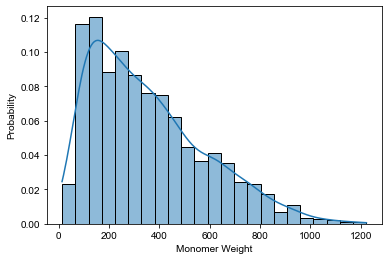

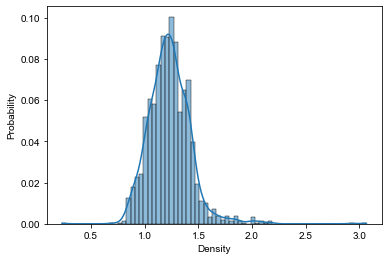

In [114]:
#Distribution Plot for monomer weight
dp = sns.histplot(x='Monomer_Weight',data=df_props, stat='probability', kde = True)
dp.set(xlabel='Monomer Weight')
plt.rcParams.update({'font.family':'Arial'})
plt.show()

#Distribution Plot for glass transition temperature
dp = sns.histplot(x='Density',data=df_props, stat ='probability', kde = True)
dp.set(xlabel='Density')
plt.rcParams.update({'font.family':'Arial'})
plt.show()

#plt.savefig('Monomer_weight_dist.png')
#plt.savefig('Sol_Param_dist.png')
#plt.savefig('Glass_Trans_dist.png')

# Keras Tuner

Below shows the code defining the deep neural network model, which has most hyperparameters chosen through Keras Tuner, a method similar to Scikit Learn's GridSearchCV(). Essentially the model starts being built by defining an input layer, which is a layer that takes in an expected tensor shape. The tensor at hand is defined by our feature vector, which in this case is a 2049-component vector. Each feature vector is individually fed into the model, so our input is really 1-dimensional, and each component of the feature vector has its own node. After this we define 3 hidden layers, which are fully connected to the layer before and after. By fully connected, it is meant that every node in the layer is connected to every node in the layer before and after. Lastly there is a final layer that only has one node, which outputs a single value, in this case being a property (glass transition temperature, solubility temperature, etc.).

The tuner works by taking multiple 'choice' parameters defined throughout the model, and running multiple variations of these parameters in the form of different models. Instead of fully running the different models, only a short sample of data is trained and tested. The tuner saves the data of all of these different model runs on your local machine and when finished going through all of the different combinations of parameters, will choose the model with the smallest validation loss (or whatever else you choose under the objective argument in kt.Hyperband() which initiates the search). This means that when there are many different values for each parameter that you would like to search for, the number of combinations dramatically increases, and the time to find the best model will also increase.

In the model below, choices are made for the tuner to search through:
- l2 or l1 regularization (this will be set at every hidden layer)
    - regularization rate: search between directly defined values
- Number of nodes in each hidden layer
    - search between a minimum and maximum number of nodes with a step size
- Dropout rate between each hidden layer
    - dropout allows for random removal of nodes during training to minimize overfitting
- Learning rate: search between directly defined values

In [115]:
#Wrapper for regulaization, will allow tuner to choose best regularization and value
def reg_wrapper(type, value):
    if type == 'l2':
        return keras.regularizers.l2(value)
    if type == 'l1':
        return keras.regularizers.l1(value)

def build_model(hp):
    reg = reg_wrapper(hp.Choice('type', ['l1', 'l2']), hp.Choice('reg_value', values=[0.01,0.001,0.1,0.005,0.05]))
    
    # Most simple tf.keras models are sequential.
    model = keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    # Describe the topography of the model. 

    # Implement L2 regularization in the first hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units1", min_value=16, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden1'))
    #add Dropout under first hidden layer
    model.add(keras.layers.Dropout(hp.Choice("Dropout_rate1", values=[0.0,0.1,0.2,0.3,0.4,0.5])))
    
    # Implement L2 regularization in the second hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units2", min_value=16, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden2'))
    #add Dropout under second hidden layer
    model.add(keras.layers.Dropout(hp.Choice("Dropout_rate2", values=[0.0,0.1,0.2,0.3,0.4,0.5])))
    
    # Implement L2 regularization in the third hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units3", min_value=16, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden3'))
    
    #no dropout layer added before the output layer. 
    
    # Define the output layer.
    model.add(keras.layers.Dense(units=1,
                                  activation='linear',
                                  name='Output',
                                  ))                              

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-1,1e-2,1e-3,1e-4])),
        loss="mean_squared_error",
        metrics=[keras.metrics.MeanSquaredError()]
    )

    return model 

In [116]:
df_D = df.dropna(subset=['Density'])

X1 = np.array(list(df_D['FP as Numpy array'].values)).astype('float64')
X2 = np.array([list(df_D['Monomer_Weight'].values)]).astype('float64')
X2=X2.T #Transpose array to line up with X1

#Standard Normalization (Z-score)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X2)
X2 = scaler.transform(X2)

X = np.concatenate((X1, X2), axis=1)

y = np.array(df_D['Density'].values).astype('float32')

input_shape = X.shape[1]

In [117]:
print(X.shape)

(1623, 2049)


In [164]:
#Partitioning the Monomer Weight data into an 80/20 train/validation split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99,shuffle=True)

In [165]:
tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=300,
    directory=os.path.normpath(r'C:\Users\Marco\Documents'),
    project_name = "Final_Report_Density"
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2,shuffle=True)

INFO:tensorflow:Reloading Oracle from existing project C:\Users\Marco\Documents\Final_Report_Density\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Marco\Documents\Final_Report_Density\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [166]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate'] + ['type'] + ['reg_value'] + ['Dropout_rate1'] + ['Dropout_rate2']:
    print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

units1 480
units2 240
units3 288
learning_rate 0.0001
type l2
reg_value 0.001
Dropout_rate1 0.1
Dropout_rate2 0.1


In [167]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden1 (Dense)              (None, 480)               984000    
_________________________________________________________________
dropout (Dropout)            (None, 480)               0         
_________________________________________________________________
Hidden2 (Dense)              (None, 240)               115440    
_________________________________________________________________
dropout_1 (Dropout)          (None, 240)               0         
_________________________________________________________________
Hidden3 (Dense)              (None, 288)               69408     
_________________________________________________________________
Output (Dense)               (None, 1)                 289       
Total params: 1,169,137
Trainable params: 1,169,137
Non-trainable params: 0
______________________________________________

In [168]:
#Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=300)

#Train Model
history = best_model.fit(
    X_train, 
    y_train,
    validation_split=0.2,
    epochs=2000,
    batch_size=20,
    shuffle=True,
    callbacks=[es]
)

#Get number of Epochs after early stoppage
epochs = history.epoch

# Model prediction against the test set.
y_pred_test = best_model.predict(X_test)

Epoch 1/2000
52/52 [==============================] - 1s 8ms/step - loss: 0.0311 - mean_squared_error: 0.0276 - val_loss: 0.0198 - val_mean_squared_error: 0.0156
Epoch 2/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0153 - mean_squared_error: 0.0109 - val_loss: 0.0159 - val_mean_squared_error: 0.0113
Epoch 3/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0125 - mean_squared_error: 0.0078 - val_loss: 0.0142 - val_mean_squared_error: 0.0096
Epoch 4/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0101 - mean_squared_error: 0.0054 - val_loss: 0.0146 - val_mean_squared_error: 0.0099
Epoch 5/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0090 - mean_squared_error: 0.0044 - val_loss: 0.0143 - val_mean_squared_error: 0.0097
Epoch 6/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0083 - mean_squared_error: 0.0037 - val_loss: 0.0148 - val_mean_squared_error: 0.0102
Epoch 7/2000
52/52 [========

52/52 [==============================] - 0s 6ms/step - loss: 0.0048 - mean_squared_error: 0.0014 - val_loss: 0.0128 - val_mean_squared_error: 0.0095
Epoch 102/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_squared_error: 0.0016 - val_loss: 0.0122 - val_mean_squared_error: 0.0089
Epoch 103/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0051 - mean_squared_error: 0.0018 - val_loss: 0.0135 - val_mean_squared_error: 0.0101
Epoch 104/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0049 - mean_squared_error: 0.0016 - val_loss: 0.0128 - val_mean_squared_error: 0.0095
Epoch 105/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0047 - mean_squared_error: 0.0013 - val_loss: 0.0129 - val_mean_squared_error: 0.0095
Epoch 106/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0046 - mean_squared_error: 0.0013 - val_loss: 0.0123 - val_mean_squared_error: 0.0090
Epoch 107/2000
52/52 [=========

52/52 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0013 - val_loss: 0.0126 - val_mean_squared_error: 0.0094
Epoch 152/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0045 - mean_squared_error: 0.0013 - val_loss: 0.0128 - val_mean_squared_error: 0.0095
Epoch 153/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_squared_error: 0.0011 - val_loss: 0.0126 - val_mean_squared_error: 0.0094
Epoch 154/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0045 - mean_squared_error: 0.0013 - val_loss: 0.0128 - val_mean_squared_error: 0.0096
Epoch 155/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0044 - mean_squared_error: 0.0012 - val_loss: 0.0130 - val_mean_squared_error: 0.0099
Epoch 156/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0045 - mean_squared_error: 0.0013 - val_loss: 0.0123 - val_mean_squared_error: 0.0091
Epoch 157/2000
52/52 [=========

52/52 [==============================] - 0s 6ms/step - loss: 0.0041 - mean_squared_error: 0.0011 - val_loss: 0.0124 - val_mean_squared_error: 0.0094
Epoch 202/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_squared_error: 0.0012 - val_loss: 0.0116 - val_mean_squared_error: 0.0086
Epoch 203/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_squared_error: 0.0013 - val_loss: 0.0125 - val_mean_squared_error: 0.0095
Epoch 204/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0042 - mean_squared_error: 0.0011 - val_loss: 0.0125 - val_mean_squared_error: 0.0095
Epoch 205/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0042 - mean_squared_error: 0.0011 - val_loss: 0.0124 - val_mean_squared_error: 0.0093
Epoch 206/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0043 - mean_squared_error: 0.0013 - val_loss: 0.0124 - val_mean_squared_error: 0.0093
Epoch 207/2000
52/52 [=========

52/52 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0011 - val_loss: 0.0124 - val_mean_squared_error: 0.0095
Epoch 252/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0011 - val_loss: 0.0125 - val_mean_squared_error: 0.0096
Epoch 253/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0011 - val_loss: 0.0121 - val_mean_squared_error: 0.0092
Epoch 254/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0011 - val_loss: 0.0121 - val_mean_squared_error: 0.0092
Epoch 255/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_squared_error: 9.9955e-04 - val_loss: 0.0122 - val_mean_squared_error: 0.0094
Epoch 256/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0011 - val_loss: 0.0124 - val_mean_squared_error: 0.0095
Epoch 257/2000
52/52 [=====

Epoch 301/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0011 - val_loss: 0.0119 - val_mean_squared_error: 0.0092
Epoch 302/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0011 - val_loss: 0.0120 - val_mean_squared_error: 0.0091
Epoch 303/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0010 - val_loss: 0.0121 - val_mean_squared_error: 0.0093
Epoch 304/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 8.4135e-04 - val_loss: 0.0119 - val_mean_squared_error: 0.0091
Epoch 305/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0040 - mean_squared_error: 0.0012 - val_loss: 0.0132 - val_mean_squared_error: 0.0103
Epoch 306/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0039 - mean_squared_error: 0.0010 - val_loss: 0.0119 - val_mean_squared_error: 0.0090
Epoch 307/20

Epoch 351/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 9.7743e-04 - val_loss: 0.0117 - val_mean_squared_error: 0.0090
Epoch 352/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 0.0010 - val_loss: 0.0135 - val_mean_squared_error: 0.0106
Epoch 353/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0039 - mean_squared_error: 0.0011 - val_loss: 0.0120 - val_mean_squared_error: 0.0093
Epoch 354/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0037 - mean_squared_error: 9.6948e-04 - val_loss: 0.0120 - val_mean_squared_error: 0.0094
Epoch 355/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0038 - mean_squared_error: 0.0011 - val_loss: 0.0126 - val_mean_squared_error: 0.0099
Epoch 356/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0038 - mean_squared_error: 0.0011 - val_loss: 0.0121 - val_mean_squared_error: 0.0093
Epoch 35

52/52 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 9.2465e-04 - val_loss: 0.0124 - val_mean_squared_error: 0.0097
Epoch 450/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 9.3916e-04 - val_loss: 0.0122 - val_mean_squared_error: 0.0096
Epoch 451/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 0.0010 - val_loss: 0.0124 - val_mean_squared_error: 0.0098
Epoch 452/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0011 - val_loss: 0.0124 - val_mean_squared_error: 0.0098
Epoch 453/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0037 - mean_squared_error: 0.0011 - val_loss: 0.0122 - val_mean_squared_error: 0.0096
Epoch 454/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 9.7010e-04 - val_loss: 0.0123 - val_mean_squared_error: 0.0096
Epoch 455/2000
52/5

52/52 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0010 - val_loss: 0.0120 - val_mean_squared_error: 0.0094
Epoch 548/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_error: 9.1432e-04 - val_loss: 0.0114 - val_mean_squared_error: 0.0089
Epoch 549/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 9.6361e-04 - val_loss: 0.0119 - val_mean_squared_error: 0.0094
Epoch 550/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 9.9725e-04 - val_loss: 0.0126 - val_mean_squared_error: 0.0100
Epoch 551/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_error: 8.8767e-04 - val_loss: 0.0116 - val_mean_squared_error: 0.0091
Epoch 552/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0011 - val_loss: 0.0125 - val_mean_squared_error: 0.0099
Epoch 553/2000


52/52 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 9.3012e-04 - val_loss: 0.0118 - val_mean_squared_error: 0.0093
Epoch 646/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 0.0011 - val_loss: 0.0118 - val_mean_squared_error: 0.0094
Epoch 647/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_error: 9.4009e-04 - val_loss: 0.0116 - val_mean_squared_error: 0.0091
Epoch 648/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0034 - mean_squared_error: 9.2888e-04 - val_loss: 0.0119 - val_mean_squared_error: 0.0094
Epoch 649/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 8.3728e-04 - val_loss: 0.0118 - val_mean_squared_error: 0.0094
Epoch 650/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0011 - val_loss: 0.0117 - val_mean_squared_error: 0.0093
Epoch 651/2000


52/52 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 8.9671e-04 - val_loss: 0.0114 - val_mean_squared_error: 0.0091
Epoch 744/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 8.5517e-04 - val_loss: 0.0115 - val_mean_squared_error: 0.0092
Epoch 745/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 9.1464e-04 - val_loss: 0.0115 - val_mean_squared_error: 0.0091
Epoch 746/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0035 - mean_squared_error: 0.0012 - val_loss: 0.0118 - val_mean_squared_error: 0.0094
Epoch 747/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0012 - val_loss: 0.0118 - val_mean_squared_error: 0.0094
Epoch 748/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0036 - mean_squared_error: 0.0013 - val_loss: 0.0116 - val_mean_squared_error: 0.0092
Epoch 749/2000
52/5

52/52 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 0.0010 - val_loss: 0.0119 - val_mean_squared_error: 0.0096
Epoch 842/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0035 - mean_squared_error: 0.0012 - val_loss: 0.0116 - val_mean_squared_error: 0.0093
Epoch 843/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 9.7361e-04 - val_loss: 0.0119 - val_mean_squared_error: 0.0095
Epoch 844/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 8.3954e-04 - val_loss: 0.0119 - val_mean_squared_error: 0.0096
Epoch 845/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 8.5022e-04 - val_loss: 0.0115 - val_mean_squared_error: 0.0093
Epoch 846/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 9.9100e-04 - val_loss: 0.0118 - val_mean_squared_error: 0.0095
Epoch 847/2000


52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 8.8502e-04 - val_loss: 0.0117 - val_mean_squared_error: 0.0095
Epoch 940/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0033 - mean_squared_error: 0.0011 - val_loss: 0.0113 - val_mean_squared_error: 0.0090
Epoch 941/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 9.7411e-04 - val_loss: 0.0116 - val_mean_squared_error: 0.0094
Epoch 942/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 9.3203e-04 - val_loss: 0.0111 - val_mean_squared_error: 0.0089
Epoch 943/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 9.0400e-04 - val_loss: 0.0114 - val_mean_squared_error: 0.0092
Epoch 944/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 8.3058e-04 - val_loss: 0.0111 - val_mean_squared_error: 0.0089
Epoch 945/2

Epoch 1037/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 8.9500e-04 - val_loss: 0.0115 - val_mean_squared_error: 0.0093
Epoch 1038/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 9.8764e-04 - val_loss: 0.0114 - val_mean_squared_error: 0.0092
Epoch 1039/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 9.3343e-04 - val_loss: 0.0112 - val_mean_squared_error: 0.0090
Epoch 1040/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 7.9953e-04 - val_loss: 0.0113 - val_mean_squared_error: 0.0091
Epoch 1041/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 8.6598e-04 - val_loss: 0.0114 - val_mean_squared_error: 0.0092
Epoch 1042/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 8.5421e-04 - val_loss: 0.0113 - val_mean_squared_

Epoch 1086/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 9.2619e-04 - val_loss: 0.0125 - val_mean_squared_error: 0.0102
Epoch 1087/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 9.0493e-04 - val_loss: 0.0112 - val_mean_squared_error: 0.0090
Epoch 1088/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 8.6816e-04 - val_loss: 0.0116 - val_mean_squared_error: 0.0094
Epoch 1089/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 9.1893e-04 - val_loss: 0.0113 - val_mean_squared_error: 0.0091
Epoch 1090/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 8.4394e-04 - val_loss: 0.0117 - val_mean_squared_error: 0.0095
Epoch 1091/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 8.7971e-04 - val_loss: 0.0114 - val_mean_squared_

Epoch 1183/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 9.6191e-04 - val_loss: 0.0114 - val_mean_squared_error: 0.0093
Epoch 1184/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0010 - val_loss: 0.0119 - val_mean_squared_error: 0.0097
Epoch 1185/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0011 - val_loss: 0.0116 - val_mean_squared_error: 0.0095
Epoch 1186/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 8.9782e-04 - val_loss: 0.0112 - val_mean_squared_error: 0.0091
Epoch 1187/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 8.7046e-04 - val_loss: 0.0115 - val_mean_squared_error: 0.0094
Epoch 1188/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 8.4774e-04 - val_loss: 0.0113 - val_mean_squared_error: 0

Epoch 1232/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 8.5717e-04 - val_loss: 0.0111 - val_mean_squared_error: 0.0089
Epoch 1233/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 8.8618e-04 - val_loss: 0.0113 - val_mean_squared_error: 0.0091
Epoch 1234/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 8.9820e-04 - val_loss: 0.0105 - val_mean_squared_error: 0.0084
Epoch 1235/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0011 - val_loss: 0.0125 - val_mean_squared_error: 0.0103
Epoch 1236/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 9.4638e-04 - val_loss: 0.0114 - val_mean_squared_error: 0.0093
Epoch 1237/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0010 - val_loss: 0.0113 - val_mean_squared_error: 0

Epoch 1281/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0033 - mean_squared_error: 0.0012 - val_loss: 0.0113 - val_mean_squared_error: 0.0092
Epoch 1282/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 8.8986e-04 - val_loss: 0.0110 - val_mean_squared_error: 0.0089
Epoch 1283/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 9.2475e-04 - val_loss: 0.0119 - val_mean_squared_error: 0.0098
Epoch 1284/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 8.7983e-04 - val_loss: 0.0115 - val_mean_squared_error: 0.0094
Epoch 1285/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 8.6973e-04 - val_loss: 0.0113 - val_mean_squared_error: 0.0092
Epoch 1286/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 7.9149e-04 - val_loss: 0.0114 - val_mean_squared_erro

Epoch 1330/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 9.3142e-04 - val_loss: 0.0111 - val_mean_squared_error: 0.0090
Epoch 1331/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0028 - mean_squared_error: 7.8858e-04 - val_loss: 0.0110 - val_mean_squared_error: 0.0090
Epoch 1332/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0010 - val_loss: 0.0120 - val_mean_squared_error: 0.0099
Epoch 1333/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0010 - val_loss: 0.0115 - val_mean_squared_error: 0.0094
Epoch 1334/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 9.5223e-04 - val_loss: 0.0110 - val_mean_squared_error: 0.0090
Epoch 1335/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 0.0010 - val_loss: 0.0114 - val_mean_squared_error: 0.009

Epoch 1379/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 9.3466e-04 - val_loss: 0.0123 - val_mean_squared_error: 0.0102
Epoch 1380/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 9.7572e-04 - val_loss: 0.0120 - val_mean_squared_error: 0.0099
Epoch 1381/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0032 - mean_squared_error: 0.0012 - val_loss: 0.0122 - val_mean_squared_error: 0.0101
Epoch 1382/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0031 - mean_squared_error: 9.8792e-04 - val_loss: 0.0113 - val_mean_squared_error: 0.0092
Epoch 1383/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0029 - mean_squared_error: 8.9212e-04 - val_loss: 0.0115 - val_mean_squared_error: 0.0094
Epoch 1384/2000
52/52 [==============================] - 0s 7ms/step - loss: 0.0030 - mean_squared_error: 9.8021e-04 - val_loss: 0.0115 - val_mean_squared_erro

Epoch 1428/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 9.7545e-04 - val_loss: 0.0111 - val_mean_squared_error: 0.0090
Epoch 1429/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0010 - val_loss: 0.0117 - val_mean_squared_error: 0.0096
Epoch 1430/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 9.5992e-04 - val_loss: 0.0113 - val_mean_squared_error: 0.0092
Epoch 1431/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 9.6010e-04 - val_loss: 0.0113 - val_mean_squared_error: 0.0092
Epoch 1432/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 9.2041e-04 - val_loss: 0.0115 - val_mean_squared_error: 0.0094
Epoch 1433/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0011 - val_loss: 0.0115 - val_mean_squared_error: 0

Epoch 1477/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 0.0010 - val_loss: 0.0111 - val_mean_squared_error: 0.0090
Epoch 1478/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 8.5614e-04 - val_loss: 0.0110 - val_mean_squared_error: 0.0090
Epoch 1479/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 9.9244e-04 - val_loss: 0.0120 - val_mean_squared_error: 0.0099
Epoch 1480/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 9.8054e-04 - val_loss: 0.0111 - val_mean_squared_error: 0.0091
Epoch 1481/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 8.9174e-04 - val_loss: 0.0112 - val_mean_squared_error: 0.0091
Epoch 1482/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0011 - val_loss: 0.0126 - val_mean_squared_error: 0

Epoch 1526/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 9.1999e-04 - val_loss: 0.0111 - val_mean_squared_error: 0.0091
Epoch 1527/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0032 - mean_squared_error: 0.0012 - val_loss: 0.0111 - val_mean_squared_error: 0.0090
Epoch 1528/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0030 - mean_squared_error: 9.4381e-04 - val_loss: 0.0107 - val_mean_squared_error: 0.0087
Epoch 1529/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0031 - mean_squared_error: 0.0010 - val_loss: 0.0113 - val_mean_squared_error: 0.0093
Epoch 1530/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 9.0647e-04 - val_loss: 0.0111 - val_mean_squared_error: 0.0091
Epoch 1531/2000
52/52 [==============================] - 0s 6ms/step - loss: 0.0029 - mean_squared_error: 9.1235e-04 - val_loss: 0.0112 - val_mean_squared_error: 0

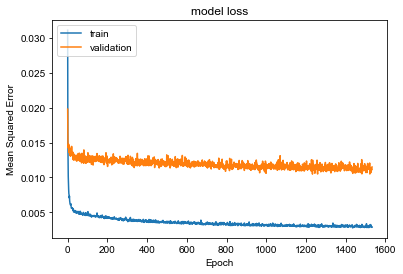

In [169]:
plot_the_loss_curve(epochs,history)

In [170]:
from sklearn.metrics import r2_score
print('Test R^2: ',r2_score(y_test, y_pred_test))
print('Train R^2: ',r2_score(y_train, best_model.predict(X_train)))

Test R^2:  0.6900560203521362
Train R^2:  0.9358670558482589


In [171]:
from sklearn.metrics import mean_squared_error
rms_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("Test RMSE: ", rms_test)

Test RMSE:  0.12727766


In [172]:
score = best_model.evaluate(X_test,y_test, verbose=0)[1]
print("Test loss: ",score)

Test loss:  0.01619959995150566


In [173]:
def plotNNpredictor(X_train,X_test,y_train,y_test):
    plt.rcParams.update({'font.family':'Arial'})
    plt.scatter(y_train,best_model.predict(X_train), label = 'Train', c='blue',edgecolors='black')
    #plt.title('Neural Network Predictor')
    plt.xlabel('Measured Density')
    plt.ylabel('Predicted Density')
    plt.scatter(y_test,best_model.predict(X_test),c='red',edgecolors='black', label='Test')
    plt.plot([y_train.min(),y_train.max()], [y_train.min(),y_train.max()], color = 'black', label = 'y = x')
    plt.legend(loc=0)
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Marco\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

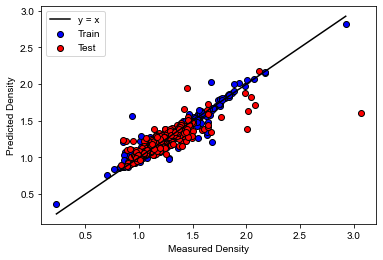

In [174]:
plotNNpredictor(X_train,X_test,y_train,y_test)

In [175]:
y_train_d2 = y_train
y_train_pred_d2 = best_model.predict(X_train)
y_test_d2 = y_test
y_test_pred_d2 = y_pred_test

### k-Fold Cross-validation

In [76]:
#Define Number of Folds
num_folds = 5

# Define per-fold score containers
r2_per_fold = []
mse_per_fold = []         #This is defined in the model as metrics=[keras.metrics.MeanSquaredError()]
loss_per_fold = []        #This is defined in the model as loss="mean_squared_error"

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):

    model = tuner.hypermodel.build(best_hps)    #Use our already tuned model
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X[train], y[train],
              epochs=700,
              verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    r2_per_fold.append(r2_score(y[test], model.predict(X[test])))
    mse_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(mse_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - R^2: {r2_per_fold[i]} - Loss: {loss_per_fold[i]} - MSE: {mse_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Test R^2: {np.mean(r2_per_fold)} \u00B1 {np.std(r2_per_fold)}')
print(f'> MSE: {np.mean(mse_per_fold)} \u00B1 {np.std(mse_per_fold)}')
print(f'> Loss: {np.mean(loss_per_fold)} \u00B1 {np.std(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 0.010993078351020813; mean_squared_error of 0.008573594503104687
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 0.020423881709575653; mean_squared_error of 0.018399668857455254
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 0.01135300938040018; mean_squared_error of 0.008892168290913105
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 0.0117954658344388; mean_squared_error of 0.009396319277584553
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 0.010743689723312855; mean_squared_error of 0.008303970098495483
---------------------------------------------------------------

# Solubility Parameter

In [176]:
df = nims4

In [177]:
df.head()

,PID,Name,Molfile,SMILES,Solubility parameter
0,P010001,polyethene,P010001.mol,*C*,16.4
1,P010002,poly(prop-1-ene),P010002.mol,*CC(*)C,17.56555555555556
2,P010003,poly(but-1-ene),P010003.mol,*CC(*)CC,15.66
3,P010008,poly(4-methylpent-1-ene),P010008.mol,*CC(*)CC(C)C,17.740000000000002
4,P010014,poly(2-methylprop-1-ene),P010014.mol,*CC(*)(C)C,16.2


In [178]:
#Generate a new dataframe with only Smiles, Fingerprints, Monomer weight, Solubility Parameter, and Glass Transition Temperature
#Since this is an old NIMS file, we have to take the average column for each desired property.

mol_list = []
for i in range(len(df.SMILES)):
    try:
        element = df.SMILES[i]
        indexed = []
        mol = Chem.MolFromSmiles(str(element)) #Use RDKit to get mol objects from the SMILES strings
        mw = Chem.Descriptors.ExactMolWt(mol) #Get the monomer weight from the mol objects
        indexed.append(i)
        indexed.append(element)
        indexed.append(mol)
        indexed.append(mw)
        indexed.append(df['Solubility parameter'][i])
        mol_list.append(indexed)
    except:
        pass


FP_list = []
numpyarrays = []

#Create Columns for Fingerprints and FPs as Numpy arrays. The arrays are easier to feed to the NN.
i = 0
baseData = np.arange(1,1)
for mol in mol_list:
    arr = np.zeros((1,))
    try:
        FP = AllChem.GetMorganFingerprintAsBitVect(mol[2], radius=3, nBits=2048)
        FP_list.append(FP)
        DataStructs.ConvertToNumpyArray(FP, arr)
        numpyarrays.append(arr)
        row = np.array([mol[0], mol[1], FP, arr, mol[3],mol[4]], dtype = object)
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1 
    except:
        i = i+1
        pass

columnNames=["Index", "SMILES","Morgan FingerPrint","FP as Numpy array","Monomer_Weight","Solubility_Parameter"]
df = pd.DataFrame(data=baseData,columns=columnNames)

In [179]:
df

,Index,SMILES,Morgan FingerPrint,FP as Numpy array,Monomer_Weight,Solubility_Parameter
0,0,*C*,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",14.0157,16.4
1,1,*CC(*)C,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",42.047,17.56555555555556
2,2,*CC(*)CC,"[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56.0626,15.66
3,3,*CC(*)CC(C)C,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",84.0939,17.740000000000002
4,4,*CC(*)(C)C,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",56.0626,16.2
...,...,...,...,...,...,...
311,311,*CCCOC(=O)O*,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",102.032,20
312,312,*Nc1ccc(*)cc1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",91.0422,21.8
313,313,*c1cccc(-c2nc3cc(-c4ccc5[nH]c(*)nc5c4)ccc3[nH...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",308.106,26.8
314,314,*O[Si](*)(C)CCC#N,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",113.03,18


In [180]:
#Remove rows with Tg values that cannot be converted to floats
index_names = []
for i in range(len(df['Solubility_Parameter'])):
    try:
        np.array(df.iloc[i]['Solubility_Parameter']).astype('float32')
    except:
        index_names.append(i)

df.drop(index=index_names, inplace = True)

In [181]:
#Convert values to numpy float arrays
Monomer_Weight = np.array(df['Monomer_Weight'].values).astype('float32')
Density = np.array(df['Solubility_Parameter'].values).astype('float32')

props = np.hstack((Monomer_Weight[:,None], Density[:,None]))

df_props = pd.DataFrame(data=props,columns=['Monomer_Weight','Solubility_Parameter'])
df_props

,Monomer_Weight,Solubility_Parameter
0,14.015650,16.400000
1,42.046951,17.565556
2,56.062599,15.660000
3,84.093903,17.740000
4,56.062599,16.200001
...,...,...
306,102.031693,20.000000
307,91.042198,21.799999
308,308.106201,26.799999
309,113.029694,18.000000


## Distribution Plots

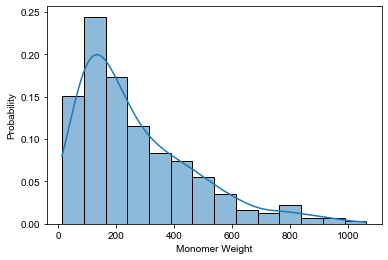

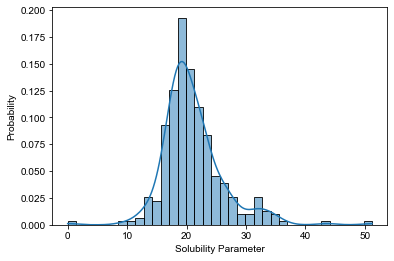

In [182]:
#Distribution Plot for monomer weight
dp = sns.histplot(x='Monomer_Weight',data=df_props, stat='probability', kde = True)
dp.set(xlabel='Monomer Weight')
plt.rcParams.update({'font.family':'Arial'})
plt.show()

#Distribution Plot for glass transition temperature
dp = sns.histplot(x='Solubility_Parameter',data=df_props, stat ='probability', kde = True)
dp.set(xlabel='Solubility Parameter')
plt.rcParams.update({'font.family':'Arial'})
plt.show()

#plt.savefig('Monomer_weight_dist.png')
#plt.savefig('Sol_Param_dist.png')
#plt.savefig('Glass_Trans_dist.png')

# Keras Tuner

Below shows the code defining the deep neural network model, which has most hyperparameters chosen through Keras Tuner, a method similar to Scikit Learn's GridSearchCV(). Essentially the model starts being built by defining an input layer, which is a layer that takes in an expected tensor shape. The tensor at hand is defined by our feature vector, which in this case is a 2049-component vector. Each feature vector is individually fed into the model, so our input is really 1-dimensional, and each component of the feature vector has its own node. After this we define 3 hidden layers, which are fully connected to the layer before and after. By fully connected, it is meant that every node in the layer is connected to every node in the layer before and after. Lastly there is a final layer that only has one node, which outputs a single value, in this case being a property (glass transition temperature, solubility temperature, etc.).

The tuner works by taking multiple 'choice' parameters defined throughout the model, and running multiple variations of these parameters in the form of different models. Instead of fully running the different models, only a short sample of data is trained and tested. The tuner saves the data of all of these different model runs on your local machine and when finished going through all of the different combinations of parameters, will choose the model with the smallest validation loss (or whatever else you choose under the objective argument in kt.Hyperband() which initiates the search). This means that when there are many different values for each parameter that you would like to search for, the number of combinations dramatically increases, and the time to find the best model will also increase.

In the model below, choices are made for the tuner to search through:
- l2 or l1 regularization (this will be set at every hidden layer)
    - regularization rate: search between directly defined values
- Number of nodes in each hidden layer
    - search between a minimum and maximum number of nodes with a step size
- Dropout rate between each hidden layer
    - dropout allows for random removal of nodes during training to minimize overfitting
- Learning rate: search between directly defined values

In [183]:
#Wrapper for regulaization, will allow tuner to choose best regularization and value
def reg_wrapper(type, value):
    if type == 'l2':
        return keras.regularizers.l2(value)
    if type == 'l1':
        return keras.regularizers.l1(value)

def build_model(hp):
    reg = reg_wrapper(hp.Choice('type', ['l1', 'l2']), hp.Choice('reg_value', values=[0.01,0.001,0.1,0.005,0.05]))
    
    # Most simple tf.keras models are sequential.
    model = keras.models.Sequential()

    # Add the layer containing the feature columns to the model.
    model.add(keras.layers.InputLayer(input_shape=input_shape))

    # Describe the topography of the model. 

    # Implement L2 regularization in the first hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units1", min_value=0, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden1'))
#     #add Dropout under first hidden layer
#     model.add(keras.layers.Dropout(hp.Choice("Dropout_rate1", values=[0.0,0.1,0.2,0.3,0.4,0.5])))
    
    # Implement L2 regularization in the second hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units2", min_value=0, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden2'))
#     #add Dropout under second hidden layer
#     model.add(keras.layers.Dropout(hp.Choice("Dropout_rate2", values=[0.0,0.1,0.2,0.3,0.4,0.5])))
    
    # Implement L2 regularization in the third hidden layer.
    model.add(keras.layers.Dense(units=hp.Int("units3", min_value=0, max_value=512,step=16), 
                                  activation='relu',
                                  kernel_regularizer=reg,
                                  name='Hidden3'))
    
    #no dropout layer added before the output layer. 
    
    # Define the output layer.
    model.add(keras.layers.Dense(units=1,
                                  activation='linear',
                                  name='Output',
                                  ))                              

    model.compile(
        optimizer=keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-1,1e-2,1e-3,1e-4])),
        loss="mean_squared_error",
        metrics=[keras.metrics.MeanSquaredError()]
    )

    return model 

In [184]:
df_SP = df.dropna(subset=['Solubility_Parameter'])

X1 = np.array(list(df_SP['FP as Numpy array'].values)).astype('float64')
X2 = np.array([list(df_SP['Monomer_Weight'].values)]).astype('float64')
X2=X2.T #Transpose array to line up with X1

#Standard Normalization (Z-score)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X2)
X2 = scaler.transform(X2)

X = np.concatenate((X1, X2), axis=1)

y = np.array(df_SP['Solubility_Parameter'].values).astype('float32')

input_shape = X.shape[1]

In [185]:
print(X.shape)

(311, 2049)


In [186]:
#Partitioning the Monomer Weight data into an 80/20 train/validation split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,shuffle=True)

In [187]:
tuner = kt.Hyperband(
    build_model,
    objective="val_loss",
    max_epochs=100,
    directory=os.path.normpath(r'C:\Users\Marco\Documents'),
    project_name = "Final_Report_SP"
)

tuner.search(X_train, y_train, epochs=50, validation_split=0.2,shuffle=True)

INFO:tensorflow:Reloading Oracle from existing project C:\Users\Marco\Documents\Final_Report_SP\oracle.json
INFO:tensorflow:Reloading Tuner from C:\Users\Marco\Documents\Final_Report_SP\tuner0.json
INFO:tensorflow:Oracle triggered exit


In [188]:
for h_param in [f"units{i}" for i in range(1,4)] + ['learning_rate'] + ['type'] + ['reg_value']:
    print(h_param, tuner.get_best_hyperparameters()[0].get(h_param))


# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

units1 32
units2 432
units3 224
learning_rate 0.01
type l2
reg_value 0.001


In [189]:
best_model = tuner.get_best_models()[0]
best_model.build(X_train.shape)
best_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Hidden1 (Dense)              (None, 32)                65600     
_________________________________________________________________
Hidden2 (Dense)              (None, 432)               14256     
_________________________________________________________________
Hidden3 (Dense)              (None, 224)               96992     
_________________________________________________________________
Output (Dense)               (None, 1)                 225       
Total params: 177,073
Trainable params: 177,073
Non-trainable params: 0
_________________________________________________________________


In [190]:
#Early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

#Train Model
history = best_model.fit(
    X_train, 
    y_train,
    validation_split=0.2,
    epochs=1000,
    batch_size=10,
    shuffle=True,
    callbacks=[es]
)

#Get number of Epochs after early stoppage
epochs = history.epoch

# Model prediction against the test set.
y_pred_test = best_model.predict(X_test)

Epoch 1/1000
20/20 [==============================] - 0s 6ms/step - loss: 88.2002 - mean_squared_error: 87.5622 - val_loss: 12.9926 - val_mean_squared_error: 12.3617
Epoch 2/1000
20/20 [==============================] - 0s 2ms/step - loss: 20.1647 - mean_squared_error: 19.5416 - val_loss: 17.7874 - val_mean_squared_error: 17.1758
Epoch 3/1000
20/20 [==============================] - 0s 2ms/step - loss: 18.8960 - mean_squared_error: 18.2917 - val_loss: 14.3256 - val_mean_squared_error: 13.7325
Epoch 4/1000
20/20 [==============================] - 0s 2ms/step - loss: 11.9754 - mean_squared_error: 11.3899 - val_loss: 21.2310 - val_mean_squared_error: 20.6533
Epoch 5/1000
20/20 [==============================] - 0s 2ms/step - loss: 13.7077 - mean_squared_error: 13.1410 - val_loss: 17.0609 - val_mean_squared_error: 16.5019
Epoch 6/1000
20/20 [==============================] - 0s 2ms/step - loss: 13.6185 - mean_squared_error: 13.0688 - val_loss: 16.3613 - val_mean_squared_error: 15.8226
Epoc

Epoch 100/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5337 - mean_squared_error: 0.2625 - val_loss: 10.2788 - val_mean_squared_error: 10.0079
Epoch 101/1000
20/20 [==============================] - 0s 2ms/step - loss: 0.5906 - mean_squared_error: 0.3194 - val_loss: 10.5427 - val_mean_squared_error: 10.2726
Epoch 00101: early stopping


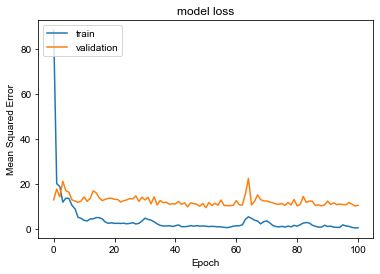

In [191]:
plot_the_loss_curve(epochs,history)

In [192]:
from sklearn.metrics import r2_score
print('Test R^2: ',r2_score(y_test, y_pred_test))
print('Train R^2: ',r2_score(y_train, best_model.predict(X_train)))

Test R^2:  0.547366273719186
Train R^2:  0.9053030942146716


In [193]:
from sklearn.metrics import mean_squared_error
rms_test = mean_squared_error(y_test, y_pred_test, squared=False)

print("Test RMSE: ", rms_test)

Test RMSE:  3.4663212


In [194]:
score = best_model.evaluate(X_test,y_test, verbose=0)[1]
print("Test loss: ",score)

Test loss:  12.015382766723633


In [195]:
def plotNNpredictor(X_train,X_test,y_train,y_test):
    plt.rcParams.update({'font.family':'Arial'})
    plt.scatter(y_train,best_model.predict(X_train), label = 'Train', c='blue',edgecolors='black')
    #plt.title('Neural Network Predictor')
    plt.xlabel('Measured Solubility Parameter')
    plt.ylabel('Predicted Solubility Parameter')
    plt.scatter(y_test,best_model.predict(X_test),c='red',edgecolors='black', label='Test')
    plt.plot([y_train.min(),y_train.max()], [y_train.min(),y_train.max()], color = 'black', label = 'y = x')
    plt.legend(loc=0)
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Marco\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

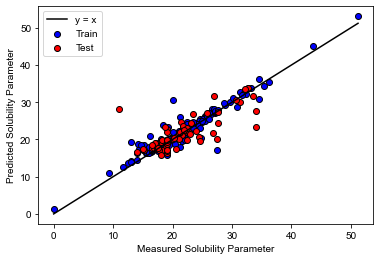

In [196]:
plotNNpredictor(X_train,X_test,y_train,y_test)

In [197]:
y_train_sp2 = y_train
y_train_pred_sp2 = best_model.predict(X_train)
y_test_sp2 = y_test
y_test_pred_sp2 = y_pred_test

### k-Fold Cross-validation

In [98]:
#Define Number of Folds
num_folds = 5

# Define per-fold score containers
r2_per_fold = []
mse_per_fold = []         #This is defined in the model as metrics=[keras.metrics.MeanSquaredError()]
loss_per_fold = []        #This is defined in the model as loss="mean_squared_error"

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(X, y):

    model = tuner.hypermodel.build(best_hps)    #Use our already tuned model
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X[train], y[train],
              epochs=700,
              verbose=0)

    # Generate generalization metrics
    scores = model.evaluate(X[test], y[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    r2_per_fold.append(r2_score(y[test], model.predict(X[test])))
    mse_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1
    
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(mse_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - R^2: {r2_per_fold[i]} - Loss: {loss_per_fold[i]} - MSE: {mse_per_fold[i]}')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Test R^2: {np.mean(r2_per_fold)} \u00B1 {np.std(r2_per_fold)}')
print(f'> MSE: {np.mean(mse_per_fold)} \u00B1 {np.std(mse_per_fold)}')
print(f'> Loss: {np.mean(loss_per_fold)} \u00B1 {np.std(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training for fold 1 ...
Score for fold 1: loss of 21.202411651611328; mean_squared_error of 21.052030563354492
------------------------------------------------------------------------
Training for fold 2 ...
Score for fold 2: loss of 18.524658203125; mean_squared_error of 18.370758056640625
------------------------------------------------------------------------
Training for fold 3 ...
Score for fold 3: loss of 7.345064640045166; mean_squared_error of 7.219513416290283
------------------------------------------------------------------------
Training for fold 4 ...
Score for fold 4: loss of 14.381671905517578; mean_squared_error of 14.17330551147461
------------------------------------------------------------------------
Training for fold 5 ...
Score for fold 5: loss of 19.154664993286133; mean_squared_error of 18.919355392456055
------------------------------------------------------------------------
Score per fol

# Plots

In [ ]:
y_train_gt1 = y_train
y_train_pred_gt1 = best_model.predict(X_train)
y_test_gt1 = y_test
y_test_pred_gt1 = y_pred_test

Text(0.8, 0.05, 'Property: $T_g$')

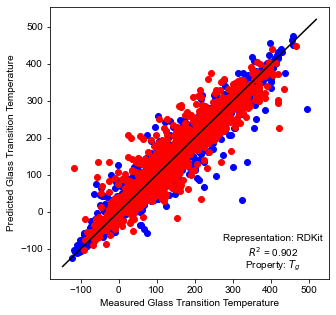

In [255]:
from pylab import text
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.family':'Arial'})
plt.scatter(y_train_gt1,y_train_pred_gt1, label = 'Train', c='blue')
plt.xlabel('Measured Glass Transition Temperature')
plt.ylabel('Predicted Glass Transition Temperature')
plt.scatter(y_test_gt1,y_test_pred_gt1,c='red', label='Test')
plt.plot([y_train_gt1.min()-25,y_train_gt1.max()+25], [y_train_gt1.min()-25,y_train_gt1.max()+25], color = 'black')
text(0.8, 0.1,"$R^2$ = {:.3f}".format(r2_score(y_test_gt1, y_test_pred_gt1)), ha='center', va='center', transform=ax.transAxes)
text(0.8, 0.15,"Representation: RDKit", ha='center', va='center', transform=ax.transAxes)
text(0.8, 0.05,"Property: $T_g$", ha='center', va='center', transform=ax.transAxes)

Text(0.8, 0.05, 'Property: $T_g$')

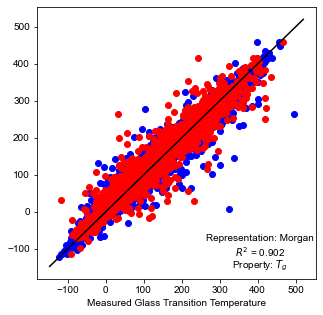

In [265]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.family':'Arial'})
plt.scatter(y_train_gt2,y_train_pred_gt2, label = 'Train', c='blue')
plt.xlabel('Measured Glass Transition Temperature')
#plt.ylabel('Predicted Glass Transition Temperature')
plt.scatter(y_test_gt2,y_test_pred_gt2,c='red', label='Test')
plt.plot([y_train_gt2.min()-25,y_train_gt2.max()+25], [y_train_gt2.min()-25,y_train_gt2.max()+25], color = 'black')
text(0.8, 0.1,"$R^2$ = {:.3f}".format(r2_score(y_test_gt2, y_test_pred_gt2)), ha='center', va='center', transform=ax.transAxes)
text(0.8, 0.15,"Representation: Morgan", ha='center', va='center', transform=ax.transAxes)
text(0.8, 0.05,"Property: $T_g$", ha='center', va='center', transform=ax.transAxes)

Text(0.8, 0.05, 'Property: ρ')

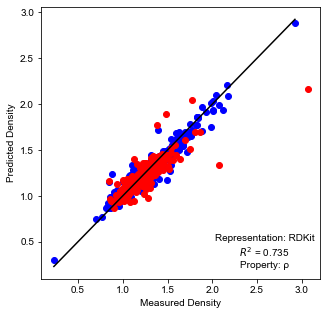

In [259]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.family':'Arial'})
plt.scatter(y_train_d1,y_train_pred_d1, label = 'Train', c='blue')
plt.xlabel('Measured Density')
plt.ylabel('Predicted Density')
plt.scatter(y_test_d1,y_test_pred_d1,c='red', label='Test')
plt.plot([y_train_d1.min(),y_train_d1.max()], [y_train_d1.min(),y_train_d1.max()], color = 'black')
text(0.8, 0.1,"$R^2$ = {:.3f}".format(r2_score(y_test_d1, y_test_pred_d1)), ha='center', va='center', transform=ax.transAxes)
text(0.8, 0.15,"Representation: RDKit", ha='center', va='center', transform=ax.transAxes)
text(0.8, 0.05,"Property: \u03C1", ha='center', va='center', transform=ax.transAxes)

Text(0.8, 0.05, 'Property: ρ')

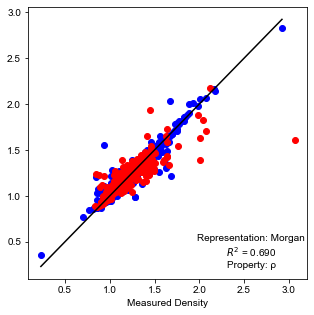

In [266]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.family':'Arial'})
plt.scatter(y_train_d2,y_train_pred_d2, label = 'Train', c='blue')
plt.xlabel('Measured Density')
#plt.ylabel('Predicted Density')
plt.scatter(y_test_d2,y_test_pred_d2,c='red', label='Test')
plt.plot([y_train_d2.min(),y_train_d2.max()], [y_train_d2.min(),y_train_d2.max()], color = 'black')
text(0.8, 0.1,"$R^2$ = {:.3f}".format(r2_score(y_test_d2, y_test_pred_d2)), ha='center', va='center', transform=ax.transAxes)
text(0.8, 0.15,"Representation: Morgan", ha='center', va='center', transform=ax.transAxes)
text(0.8, 0.05,"Property: \u03C1", ha='center', va='center', transform=ax.transAxes)

Text(0.8, 0.05, 'Property: $SP$')

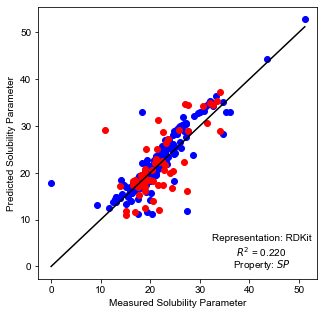

In [270]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.family':'Arial'})
plt.scatter(y_train_sp1,y_train_pred_sp1, label = 'Train', c='blue')
plt.xlabel('Measured Solubility Parameter')
plt.ylabel('Predicted Solubility Parameter')
plt.scatter(y_test_sp1,y_test_pred_sp1,c='red', label='Test')
plt.plot([y_train_sp1.min(),y_train_sp1.max()], [y_train_sp1.min(),y_train_sp1.max()], color = 'black')
text(0.8, 0.1,"$R^2$ = {:.3f}".format(r2_score(y_test_sp1, y_test_pred_sp1)), ha='center', va='center', transform=ax.transAxes)
text(0.8, 0.15,"Representation: RDKit", ha='center', va='center', transform=ax.transAxes)
text(0.8, 0.05,"Property: $SP$", ha='center', va='center', transform=ax.transAxes)

Text(0.8, 0.05, 'Property: $SP$')

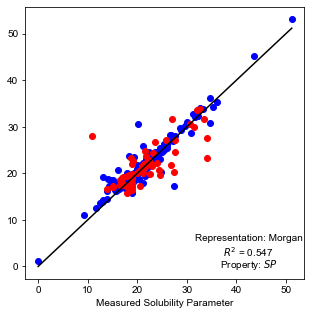

In [269]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.rcParams.update({'font.family':'Arial'})
plt.scatter(y_train_sp2,y_train_pred_sp2, label = 'Train', c='blue')
plt.xlabel('Measured Solubility Parameter')
#plt.ylabel('Predicted Solubility Parameter')
plt.scatter(y_test_sp2,y_test_pred_sp2,c='red', label='Test')
plt.plot([y_train_sp2.min(),y_train_sp2.max()], [y_train_sp2.min(),y_train_sp2.max()], color = 'black')
text(0.8, 0.1,"$R^2$ = {:.3f}".format(r2_score(y_test_sp2, y_test_pred_sp2)), ha='center', va='center', transform=ax.transAxes)
text(0.8, 0.15,"Representation: Morgan", ha='center', va='center', transform=ax.transAxes)
text(0.8, 0.05,"Property: $SP$", ha='center', va='center', transform=ax.transAxes)

In [2]:
nims2 = pd.read_excel("GlassTransition.xlsx")
nims3 = pd.read_excel("Density.xlsx")
nims4 = pd.read_excel("Solubility.xlsx")

#Remove rows with Tg values that cannot be converted to floats
index_names = []
for i in range(len(nims2['Glass transition temp.'])):
    try:
        np.array(nims2.iloc[i]['Glass transition temp.']).astype('float32')
    except:
        index_names.append(i)

nims2.drop(index=index_names, inplace = True)

#Remove rows with Tg values that cannot be converted to floats
index_names = []
for i in range(len(nims3['Density'])):
    try:
        np.array(nims3.iloc[i]['Density']).astype('float32')
    except:
        index_names.append(i)

nims3.drop(index=index_names, inplace = True)

#Remove rows with Tg values that cannot be converted to floats
index_names = []
for i in range(len(nims4['Solubility parameter'])):
    try:
        np.array(nims4.iloc[i]['Solubility parameter']).astype('float32')
    except:
        index_names.append(i)

nims4.drop(index=index_names, inplace = True)

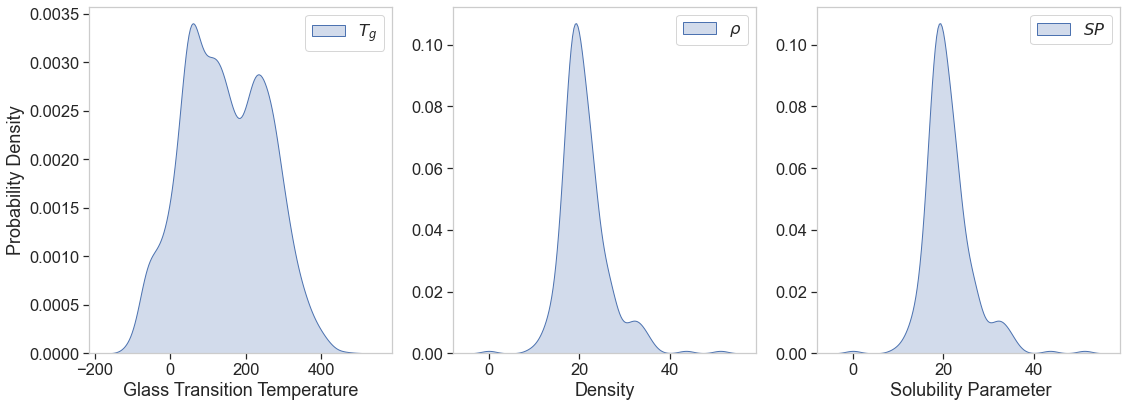

In [33]:
sns.set_style("whitegrid", {'axes.grid' : False})

plt.rcParams['xtick.bottom'] = True
plt.rcParams['ytick.left'] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(1,3, figsize=(16,6))

ax1 = sns.kdeplot(data=Glass_Transition, ax=ax[0], label = '$T_{g}$',shade=True)
ax1.grid(False)
ax1.set(ylabel="Probability Density", xlabel="Glass Transition Temperature")
ax1.legend()

ax2 = sns.kdeplot(data=Density, ax=ax[1], label = '$\u03C1$',shade=True)
ax2.set(ylabel=None, xlabel="Density")
ax2.legend()

ax3 = sns.kdeplot(data=Solubility_Parameter, ax=ax[2], label = '$SP$', shade=True)
ax3.set(ylabel=None, xlabel=" Solubility Parameter")
ax3.legend()

plt.tight_layout()
sns.set(font_scale = 1.5)